In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-risk-dataset-csv/credit_risk_dataset.csv
/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


# **`1. Import Required Libraries`**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats

%matplotlib inline
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [3]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# **`2. Load Data`**

In [4]:
data1 = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
data2 = pd.read_csv('/kaggle/input/credit-risk-dataset-csv/credit_risk_dataset.csv')
print('Data Loaded')

Data Loaded


# **`3. Overview of the Data`**
## **`3.1. General Overview`**

In [5]:
print(f"Number of entries in the data1: {data1.shape[0]}")
print(f"Number of features in the data1: {data1.shape[1]}\n")

print(f"Number of entries in the data2: {data2.shape[0]}")
print(f"Number of features in the data2: {data2.shape[1]}")

Number of entries in the data1: 58645
Number of features in the data1: 13

Number of entries in the data2: 32581
Number of features in the data2: 12


In [6]:
data1.head()

id  person_age  person_income person_home_ownership  person_emp_length  \
0   0          37          35000                  RENT                0.0   
1   1          22          56000                   OWN                6.0   
2   2          29          28800                   OWN                8.0   
3   3          30          70000                  RENT               14.0   
4   4          22          60000                  RENT                2.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0   EDUCATION          B       6000          11.49                 0.17   
1     MEDICAL          C       4000          13.35                 0.07   
2    PERSONAL          A       6000           8.90                 0.21   
3     VENTURE          B      12000          11.11                 0.17   
4     MEDICAL          A       6000           6.92                 0.10   

  cb_person_default_on_file  cb_person_cred_hist_length  loan_status  
0                         N                          14            0  
1                         N                           2            0  
2                         N                          10            0  
3                         N                           5            0  
4                         N                           3            0

In [7]:
data2.head()

person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  
1                 0.10                         N                           2  
2                 0.57                         N                           3  
3                 0.53                         N                           2  
4                 0.55                         Y                           4

### **`Concatenate 2 dataframes`**

In [8]:
data = pd.concat([data1, data2], axis = 0, ignore_index = True)
data.head()

id  person_age  person_income person_home_ownership  person_emp_length  \
0  0.0          37          35000                  RENT                0.0   
1  1.0          22          56000                   OWN                6.0   
2  2.0          29          28800                   OWN                8.0   
3  3.0          30          70000                  RENT               14.0   
4  4.0          22          60000                  RENT                2.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0   EDUCATION          B       6000          11.49                 0.17   
1     MEDICAL          C       4000          13.35                 0.07   
2    PERSONAL          A       6000           8.90                 0.21   
3     VENTURE          B      12000          11.11                 0.17   
4     MEDICAL          A       6000           6.92                 0.10   

  cb_person_default_on_file  cb_person_cred_hist_length  loan_status  
0                         N                          14            0  
1                         N                           2            0  
2                         N                          10            0  
3                         N                           5            0  
4                         N                           3            0

## **`3.2. Overview of Features - Name & Datatype`**
- `Data Conformity` check

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91226 entries, 0 to 91225
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  float64
 1   person_age                  91226 non-null  int64  
 2   person_income               91226 non-null  int64  
 3   person_home_ownership       91226 non-null  object 
 4   person_emp_length           90331 non-null  float64
 5   loan_intent                 91226 non-null  object 
 6   loan_grade                  91226 non-null  object 
 7   loan_amnt                   91226 non-null  int64  
 8   loan_int_rate               88110 non-null  float64
 9   loan_percent_income         91226 non-null  float64
 10  cb_person_default_on_file   91226 non-null  object 
 11  cb_person_cred_hist_length  91226 non-null  int64  
 12  loan_status                 91226 non-null  int64  
dtypes: float64(4), int64(5), object

#### **3.1. & 3.2. Observations**
- There are **91226** records/entries and **13** columns/features in the dataset.
- Datatypes of features seem to be correct.
- Datatypes of features - **5 int**, **4 object** & **4 float**
- There are **null** values in few features. We will instigate them in the later section. 

## **`3.3. Check for Duplicate Entries`**
- `Data Uniqueness` check 

In [10]:
if data.iloc[1:].duplicated().sum() > 0:
    print(f"There are {data.iloc[1:].duplicated().sum()} duplicate entries/rows in the data.")
else:
    print('There are no duplicate entries/rows in the data.')

There are 165 duplicate entries/rows in the data.


## **`3.4. Check for Missing Values`**
- `Data Completeness` check

In [11]:
def check_missing_values(data):
    flag = 0
    
    missing_values = []
    col_names = []
    mv_percentage = []
    print('Missing Values:\n')
    
    for col in data.columns:
        if data[col].isnull().sum() > 0:
            flag = 1
            missing_values.append(data[col].isnull().sum())
            mv_percentage.append(round(data[col].isnull().sum()*100/data.shape[0],2))
            col_names.append(col)
    else:
        if flag == 0:
            print('There are no missing values in the data.')
            
    mv_df = pd.DataFrame(data = {'values': missing_values, 
                                 'percentage': mv_percentage},
                         index = col_names)
    mv_df = mv_df.rename_axis(index = 'feature')
    mv_df = mv_df.sort_values(by = 'values', ascending = False)
    display(mv_df)

In [12]:
check_missing_values(data.drop_duplicates(keep = 'first'))

Missing Values:



values  percentage
feature                              
id                  32416       35.60
loan_int_rate        3095        3.40
person_emp_length     887        0.97

#### **3.4. Observations**
- **id** feature is the **unique identifier** assigned to customers for their loan. It doesn't add any information to our prediction, so 'id' can be dropped for predictive analysis.
- Missing values as seen above will be handled after further exploration of those features.

## **`3.5. Check for Data Correctness`**
- `Data Accuracy`, `Data Consistency`, `Data Validation` & `Data Relevancy` check

In [13]:
cat_data_summary = (
    data
    .select_dtypes('object')
    .describe()
    .T
    .sort_values(by = 'unique')
    .rename_axis(index = 'feature')
)

display(cat_data_summary)

count unique        top   freq
feature                                                  
cb_person_default_on_file  91226      2          N  76779
person_home_ownership      91226      4       RENT  47040
loan_intent                91226      6  EDUCATION  18724
loan_grade                 91226      7          A  31761

In [14]:
cat_list = cat_data_summary.index.to_list()
print('Feature-wise unique categories:\n')
for col in cat_list:
   print(f"{col}:\n{data[col].unique()}\n")

Feature-wise unique categories:

cb_person_default_on_file:
['N' 'Y']

person_home_ownership:
['RENT' 'OWN' 'MORTGAGE' 'OTHER']

loan_intent:
['EDUCATION' 'MEDICAL' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']

loan_grade:
['B' 'C' 'A' 'D' 'E' 'F' 'G']



In [15]:
(
    data
    .select_dtypes('number')
    .describe()
    .T
    .rename_axis(index = 'feature')
)

count          mean           std      min  \
feature                                                                    
id                          58645.0  29322.000000  16929.497605     0.00   
person_age                  91226.0     27.616480      6.148115    20.00   
person_income               91226.0  64770.706224  47936.961097  4000.00   
person_emp_length           90331.0      4.732119      4.025068     0.00   
loan_amnt                   91226.0   9350.348607   5848.605423   500.00   
loan_int_rate               88110.0     10.789508      3.108998     5.42   
loan_percent_income         91226.0      0.163154      0.097491     0.00   
cb_person_cred_hist_length  91226.0      5.810219      4.038412     2.00   
loan_status                 91226.0      0.169447      0.375149     0.00   

                                 25%       50%       75%         max  
feature                                                               
id                          14661.00  29322.00  43983.00    58644.00  
person_age                     23.00     26.00     30.00      144.00  
person_income               40000.00  57000.00  78000.00  6000000.00  
person_emp_length               2.00      4.00      7.00      123.00  
loan_amnt                    5000.00   8000.00  12000.00    35000.00  
loan_int_rate                   7.88     10.95     13.11       23.22  
loan_percent_income             0.09      0.14      0.22        0.83  
cb_person_cred_hist_length      3.00      4.00      8.00       30.00  
loan_status                     0.00      0.00      0.00        1.00

In [16]:
for col in cat_list:
    count = data[col].value_counts()
    proportion = data[col].value_counts(normalize = True) * 100
    distribution_df = pd.concat([count,proportion], axis = 1)
    distribution_df.columns = ['count','percentage']
    print(f"Distribution of {col} Feature:")
    display(distribution_df)

Distribution of cb_person_default_on_file Feature:


count  percentage
cb_person_default_on_file                   
N                          76779   84.163506
Y                          14447   15.836494

Distribution of person_home_ownership Feature:


count  percentage
person_home_ownership                   
RENT                   47040   51.564247
MORTGAGE               38268   41.948567
OWN                     5722    6.272335
OTHER                    196    0.214851

Distribution of loan_intent Feature:


count  percentage
loan_intent                         
EDUCATION          18724   20.524850
MEDICAL            17005   18.640519
VENTURE            15730   17.242891
PERSONAL           15537   17.031329
DEBTCONSOLIDATION  14345   15.724684
HOMEIMPROVEMENT     9885   10.835727

Distribution of loan_grade Feature:


count  percentage
loan_grade                   
A           31761   34.815732
B           30851   33.818210
C           17494   19.176551
D            8660    9.492908
E            1973    2.162761
F             390    0.427510
G              97    0.106329

In [17]:
data[data.loc[:,'person_age'] > 100]

id  person_age  person_income person_home_ownership  \
47336  47336.0         123          36000              MORTGAGE   
58726      NaN         144         250000                  RENT   
58828      NaN         144         200000              MORTGAGE   
59220      NaN         123          80004                  RENT   
59392      NaN         123          78000                  RENT   
90942      NaN         144        6000000              MORTGAGE   

       person_emp_length loan_intent loan_grade  loan_amnt  loan_int_rate  \
47336                7.0    PERSONAL          B       6700          10.75   
58726                4.0     VENTURE          C       4800          13.57   
58828                4.0   EDUCATION          B       6000          11.86   
59220                2.0   EDUCATION          B      20400          10.25   
59392                7.0     VENTURE          B      20000            NaN   
90942               12.0    PERSONAL          C       5000          12.73   

       loan_percent_income cb_person_default_on_file  \
47336                 0.18                         N   
58726                 0.02                         N   
58828                 0.03                         N   
59220                 0.25                         N   
59392                 0.26                         N   
90942                 0.00                         N   

       cb_person_cred_hist_length  loan_status  
47336                           4            0  
58726                           3            0  
58828                           2            0  
59220                           3            0  
59392                           4            0  
90942                          25            0

In [18]:
data[data['person_emp_length'] > 100]

id  person_age  person_income person_home_ownership  \
41079  41079.0          28          60350              MORTGAGE   
49252  49252.0          21         192000              MORTGAGE   
58645      NaN          22          59000                  RENT   
58855      NaN          21         192000              MORTGAGE   

       person_emp_length loan_intent loan_grade  loan_amnt  loan_int_rate  \
41079              123.0     MEDICAL          D      25000          15.95   
49252              123.0     VENTURE          B      20000          11.49   
58645              123.0    PERSONAL          D      35000          16.02   
58855              123.0     VENTURE          A      20000           6.54   

       loan_percent_income cb_person_default_on_file  \
41079                 0.35                         Y   
49252                 0.10                         N   
58645                 0.59                         Y   
58855                 0.10                         N   

       cb_person_cred_hist_length  loan_status  
41079                           6            1  
49252                           2            0  
58645                           3            1  
58855                           4            0

In [19]:
(
    data
    .fillna({'person_emp_length': data['person_emp_length'].median(),
             'loan_int_rate': data['loan_int_rate'].median()})
    .assign(
        age_at_first_loan = lambda df_: df_['person_age'] - df_['cb_person_cred_hist_length'],
        age_at_first_emp = lambda df_: df_['person_age'] - df_['person_emp_length']
    )
    .query('age_at_first_emp < 14 or age_at_first_loan < 16')
).shape

(46, 15)

#### **3.5. Observations**
- There are a few observations with **person_age** values as **123 & 144 years** and **person_emp_length** values as **123 years**, which **aren't logical**. Data to be filtered excluding age & employment length above 100 years.
- Additionally, there are approximately **45** observations where individuals were employed before the **age** of **14** or received their first **credit** before the age of **16**. To ensure data accuracy and consistency with Indian standards, such observations should be **removed**, as the **minimum age eligibility** for **loans** is **16** years and the **minimum legal working age** is **14** years, as per labor laws.

# **`4. Data Cleaning`**

In [20]:
df1 = (
    data
    .drop(columns = ['id'])
    .drop_duplicates(keep = 'first')
    .fillna({'person_emp_length': data['person_emp_length'].median(),
             'loan_int_rate': data['loan_int_rate'].median()})
    .assign(
        age_at_first_loan = lambda df_: df_['person_age'] - df_['cb_person_cred_hist_length'],
        age_at_first_emp = lambda df_: df_['person_age'] - df_['person_emp_length']
    )
)

In [21]:
df1 = (
    df1
    .loc[
    (df1['age_at_first_emp'] > 14) & 
    (df1['age_at_first_loan'] > 16) & 
    (df1['person_age'] <= 100) & 
    ((df1['person_emp_length'] <= 100) | (df1['person_emp_length'].isna()))
    ]
    .drop(columns = ['age_at_first_loan', 'age_at_first_emp'])
)

In [22]:
df1.sample(5)

person_age  person_income person_home_ownership  person_emp_length  \
49928          21          35000                   OWN                5.0   
86466          27          79636                  RENT               11.0   
18546          28          60000                  RENT                2.0   
42123          29          36000                  RENT                0.0   
60569          21          30000                   OWN                5.0   

             loan_intent loan_grade  loan_amnt  loan_int_rate  \
49928           PERSONAL          A       6000           6.03   
86466           PERSONAL          D      19200          13.87   
18546          EDUCATION          B       5000           9.63   
42123  DEBTCONSOLIDATION          D       5000          10.99   
60569            MEDICAL          A       9000           5.99   

       loan_percent_income cb_person_default_on_file  \
49928                 0.17                         N   
86466                 0.24                         Y   
18546                 0.08                         N   
42123                 0.14                         N   
60569                 0.30                         N   

       cb_person_cred_hist_length  loan_status  
49928                           2            0  
86466                           9            0  
18546                           8            0  
42123                           6            1  
60569                           4            0

In [23]:
check_missing_values(df1)

Missing Values:

There are no missing values in the data.


Empty DataFrame
Columns: [values, percentage]
Index: []

In [24]:
df1.duplicated().sum()

1

In [25]:
df = df1.drop_duplicates(keep = 'first', ignore_index = True)
print('Data Cleaned!')

Data Cleaned!


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90970 entries, 0 to 90969
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  90970 non-null  int64  
 1   person_income               90970 non-null  int64  
 2   person_home_ownership       90970 non-null  object 
 3   person_emp_length           90970 non-null  float64
 4   loan_intent                 90970 non-null  object 
 5   loan_grade                  90970 non-null  object 
 6   loan_amnt                   90970 non-null  int64  
 7   loan_int_rate               90970 non-null  float64
 8   loan_percent_income         90970 non-null  float64
 9   cb_person_default_on_file   90970 non-null  object 
 10  cb_person_cred_hist_length  90970 non-null  int64  
 11  loan_status                 90970 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 8.3+ MB


# **`5. Exploratory Data Analysis`**

In [27]:
categorical_features = df.select_dtypes('object').columns.to_list()
numerical_features = df.select_dtypes('number').columns.to_list()

### **`Helper Functions`**

In [28]:
def count_plot(data, features, target_col = None, size_x = 10,
               size_y = 6, title_size = 12, xticks_size = 14,
               xlabel_size = 15, ylabel_size = 15, padding = -20):
    num_plots = len(features)
    num_cols = 2
    num_rows = (num_plots + num_cols - 1) // num_cols
    
    plt.figure(figsize = (size_x,size_y))
    for i, col in enumerate(features):
        
        plt.subplot(num_rows,num_cols,i+1)
        ax = sns.countplot(data = data, x = col, hue = target_col, edgecolor = 'black',
                           order = data[col].value_counts().index, palette = 'Spectral')
        for bars in ax.containers:
            ax.bar_label(bars, fontsize = 13, padding = padding)
            
        plt.xticks(rotation = 25, ha='right', fontsize = xticks_size)
        plt.xlabel(col, fontdict = {'size' : xlabel_size})
        plt.ylabel('Count', fontdict = {'size' : ylabel_size})
        plt.title(f"Count of '{col}' Feature", fontdict = {'size' : title_size})
        
        if target_col!= None:
            plt.legend(title = target_col)
            plt.title(f"Count of Loan Status by '{col}' Feature", fontdict = {'size' : title_size})
    plt.tight_layout()
    plt.show()

In [29]:
def pie_plot(data, features, size_x = 10, size_y = 6, title_size = 20):
    num_plots = len(features)
    num_cols = 2
    num_rows = (num_plots + num_cols - 1) // num_cols
    
    plt.figure(figsize = (size_x,size_y))
    for i, col in enumerate(features):
    
        values = data[col].value_counts().values
        labels = data[col].value_counts().index
        explode = [0.05 for label in range(len(labels))]
        
        plt.subplot(num_rows,num_cols,i+1)
        ax = plt.pie(x = values, labels = labels, autopct = '%0.2f%%', explode = explode)
        plt.title(f"Distribution of '{col}' Feature", fontdict = {'size' : title_size})
        plt.legend(bbox_to_anchor=(1, 1))
        plt.tight_layout()
    plt.show()

In [30]:
def bar_plot(data, features, target, hue = None, size_x = 10, size_y = 4,
             xlabel_size = 12, ylabel_size = 12, title_size = 15, bar_annot = 1):
    num_plots = len(features)
    num_cols = 2
    num_rows = (num_plots + num_cols - 1) // num_cols
    
    plt.figure(figsize = (size_x,size_y))

    for i, col in enumerate(features):
        plt.subplot(num_rows, num_cols, i + 1)
        if hue == None:
            ax = sns.barplot(data = data, x = col, y = target, errorbar = None,
                             palette = 'Set1', edgecolor = 'black')
        else:
            ax = sns.barplot(data = data, x = col, y = target, hue = hue,
                            palette = 'Set1', edgecolor = 'black', errorbar = None,)  
        if bar_annot == 1:
            for bars in ax.containers:
                ax.bar_label(bars)
        plt.xticks(rotation = 25, ha = 'right')
        plt.title(f'{target} vs {col}', fontsize = title_size)
        plt.xlabel(col, fontsize = xlabel_size)
        plt.ylabel(target, fontsize = ylabel_size)
        plt.legend(bbox_to_anchor = (1,1))
    plt.tight_layout()
    plt.show()

In [31]:
def bivariate_plot(data, features, target, hue = None, size_x = 10, size_y = 6):
    num_plots = len(features)
    num_cols = 2
    num_rows = (num_plots + num_cols - 1) // num_cols
    
    plt.figure(figsize=(size_x, size_y))
    
    for i, col in enumerate(features):
        df_group = data.groupby(by=col)[target].mean().sort_values(ascending=False)
        df_sorted = df_group.to_frame().reset_index()
    
        plt.subplot(num_rows, num_cols, i + 1)
        ax = sns.barplot(data=df_sorted, x=col, y=target, hue = hue, edgecolor='black', 
                         palette='Spectral', order=df_sorted[col])
    
        for bars in ax.containers:
            ax.bar_label(bars, fontsize=14,
                         labels=[f'{(label.get_height() * 100):0.2f}%' for label in bars],
                         padding=0)
        plt.xticks(rotation=25, ha='right', fontsize=12)
        plt.xlabel(col, fontdict={'size': 15})
        plt.ylabel(target.capitalize(), fontdict={'size': 15})
        plt.title(f"Average {target} vs '{col}' Feature", fontdict={'size': 20})
        plt.tight_layout()
    
    plt.show()

In [32]:
def multivariate_plot(data, col, x, y, title_template, order = None, col_wrap = 3, hue = None,
                      height = 4, aspect = 1.2, sharex = False, sharey = False, flag = 0):
    
    fg = sns.FacetGrid(data = data, col = col, col_wrap = col_wrap, height=height, 
                       aspect = aspect, sharex = sharex, sharey = sharey)
    if hue == None:
        fg.map(sns.barplot, x, y, order = order, 
               errorbar = None, palette = 'Set1', edgecolor = 'black')
    else:
        fg.map(sns.barplot, x, y, hue = df[hue], order = order, 
               errorbar = None, palette = 'Set1', edgecolor = 'black')
        plt.legend(title = hue.capitalize(), bbox_to_anchor = (1,1))

    # fg.set_axis_labels(col1, col2)
    fg.set_xlabels(x.capitalize())
    fg.set_ylabels(y.capitalize())
    fg.set_titles(template = title_template)
    
    for ax in fg.axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')
        if flag == 0:
            for bars in ax.containers:
                ax.bar_label(bars, 
                             labels=[f'{(label.get_height() * 100):0.2f}%' for label in bars],
                             padding=0)
    
    plt.tight_layout()
    plt.show()

In [33]:
def hist_plot(data, features, hue = None, kde = True, size_x = 10, size_y = 6,
              xlabel_size = 12, ylabel_size = 12, title_size = 15):

    num_plots = len(features)
    num_cols = 2
    num_rows = (num_plots + num_cols - 1) // num_cols
    
    plt.figure(figsize = (size_x, size_y))
    
    for i, col in enumerate(features):
        plt.subplot(num_rows, num_cols, i+1)
        if hue == None:
            sns.histplot(data = data, x = col, kde = kde)
            sns.rugplot(data = data, x = col, color = 'black')
        else:
            sns.kdeplot(data = data[data.loc[:, hue] == 0], x = col, fill = True, label = 'Rejected')
            sns.kdeplot(data = data[data.loc[:, hue] == 1], x = col, fill = True, label = 'Approved')
        plt.xticks(rotation = 25, ha = 'right')
        plt.xlabel(col, fontsize = xlabel_size)
        plt.ylabel('Count', fontsize = ylabel_size)
        plt.legend()
        plt.title(f'Distribution - {col}', fontsize = title_size)

    plt.tight_layout()
    plt.show()

In [34]:
def box_plot(data, features, hue = None, size_x = 10, size_y = 6,
             xlabel_size = 12, title_size = 15):

    num_plots = len(features)
    num_cols = 2
    num_rows = (num_plots + num_cols - 1) // num_cols
    
    plt.figure(figsize = (size_x, size_y))
    
    for i, col in enumerate(features):    
        plt.subplot(num_rows, num_cols, i+1)
        sns.boxplot(data = data, x = col, hue = hue)
        plt.xticks(rotation = 25, ha = 'right')
        plt.xlabel(col, fontsize = xlabel_size)
        plt.title(f'Boxplot - {col}', fontsize = title_size)
        
    plt.tight_layout()
    plt.show()

## **`5.1. EDA - Target Feature`**

### **`5.1.1. Basic Descriptive Stats`**

In [35]:
df['loan_status'].describe().to_frame().T

count      mean       std  min  25%  50%  75%  max
loan_status  90970.0  0.169506  0.375201  0.0  0.0  0.0  0.0  1.0

### **`5.1.2. Univariate Analysis`**

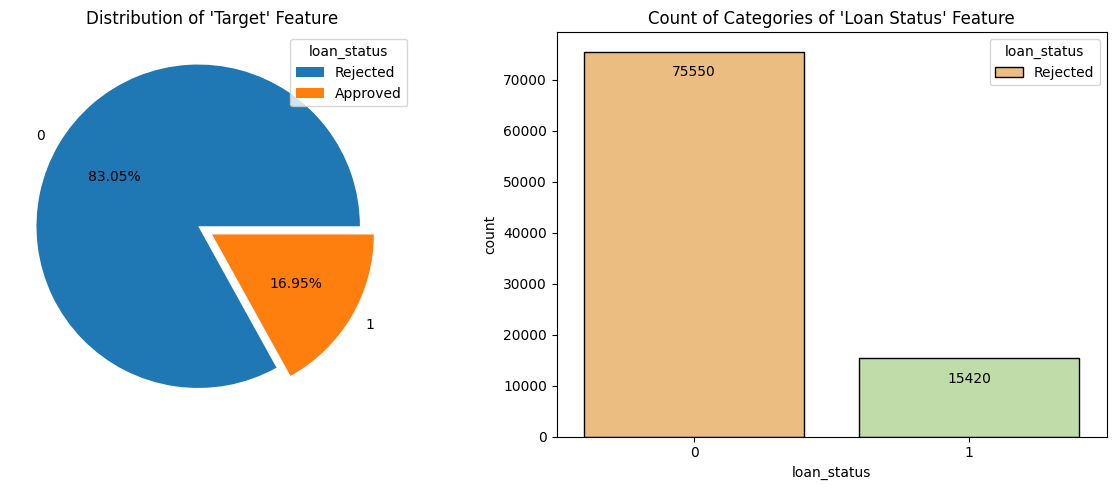

In [36]:
values = df['loan_status'].value_counts().values
labels = df['loan_status'].value_counts().index

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pie(x = values, labels = labels, autopct = '%0.2f%%', explode = [0.1, 0])
plt.legend(title = 'loan_status', labels=['Rejected', 'Approved'])
plt.title("Distribution of 'Target' Feature")

plt.subplot(1, 2, 2)
ax = sns.countplot(data = df, x = 'loan_status', edgecolor = 'black', palette = 'Spectral')
for bars in ax.containers:
    ax.bar_label(bars, padding = -20)
plt.legend(title = 'loan_status', labels = ['Rejected', 'Approved'])
plt.title("Count of Categories of 'Loan Status' Feature")

plt.tight_layout()
plt.show()

#### **`5.1. Observations`**
- Only **16.95% (15420 out of 90970)** loans are **approved**.
- Majority of loans - **83.05% (75550) loans are **rejected**.
- The distribution of **loan_status** feature is highly **imbalanced**, however the necessary steps for handling the imbalance to be taken in the later stage of modeling.

## **`5.2. EDA - Categorical Features`**

### **`5.2.1. Basic Descriptive Stats`**

In [37]:
cat_features_summary = (
    df
    .select_dtypes('object')
    .describe()
    .T
    .sort_values(by = 'unique')
    .rename_axis(index = 'feature')
)

display(cat_features_summary)

count unique        top   freq
feature                                                  
cb_person_default_on_file  90970      2          N  76552
person_home_ownership      90970      4       RENT  46932
loan_intent                90970      6  EDUCATION  18665
loan_grade                 90970      7          A  31657

### **`5.2.2. Univariate Analysis`**

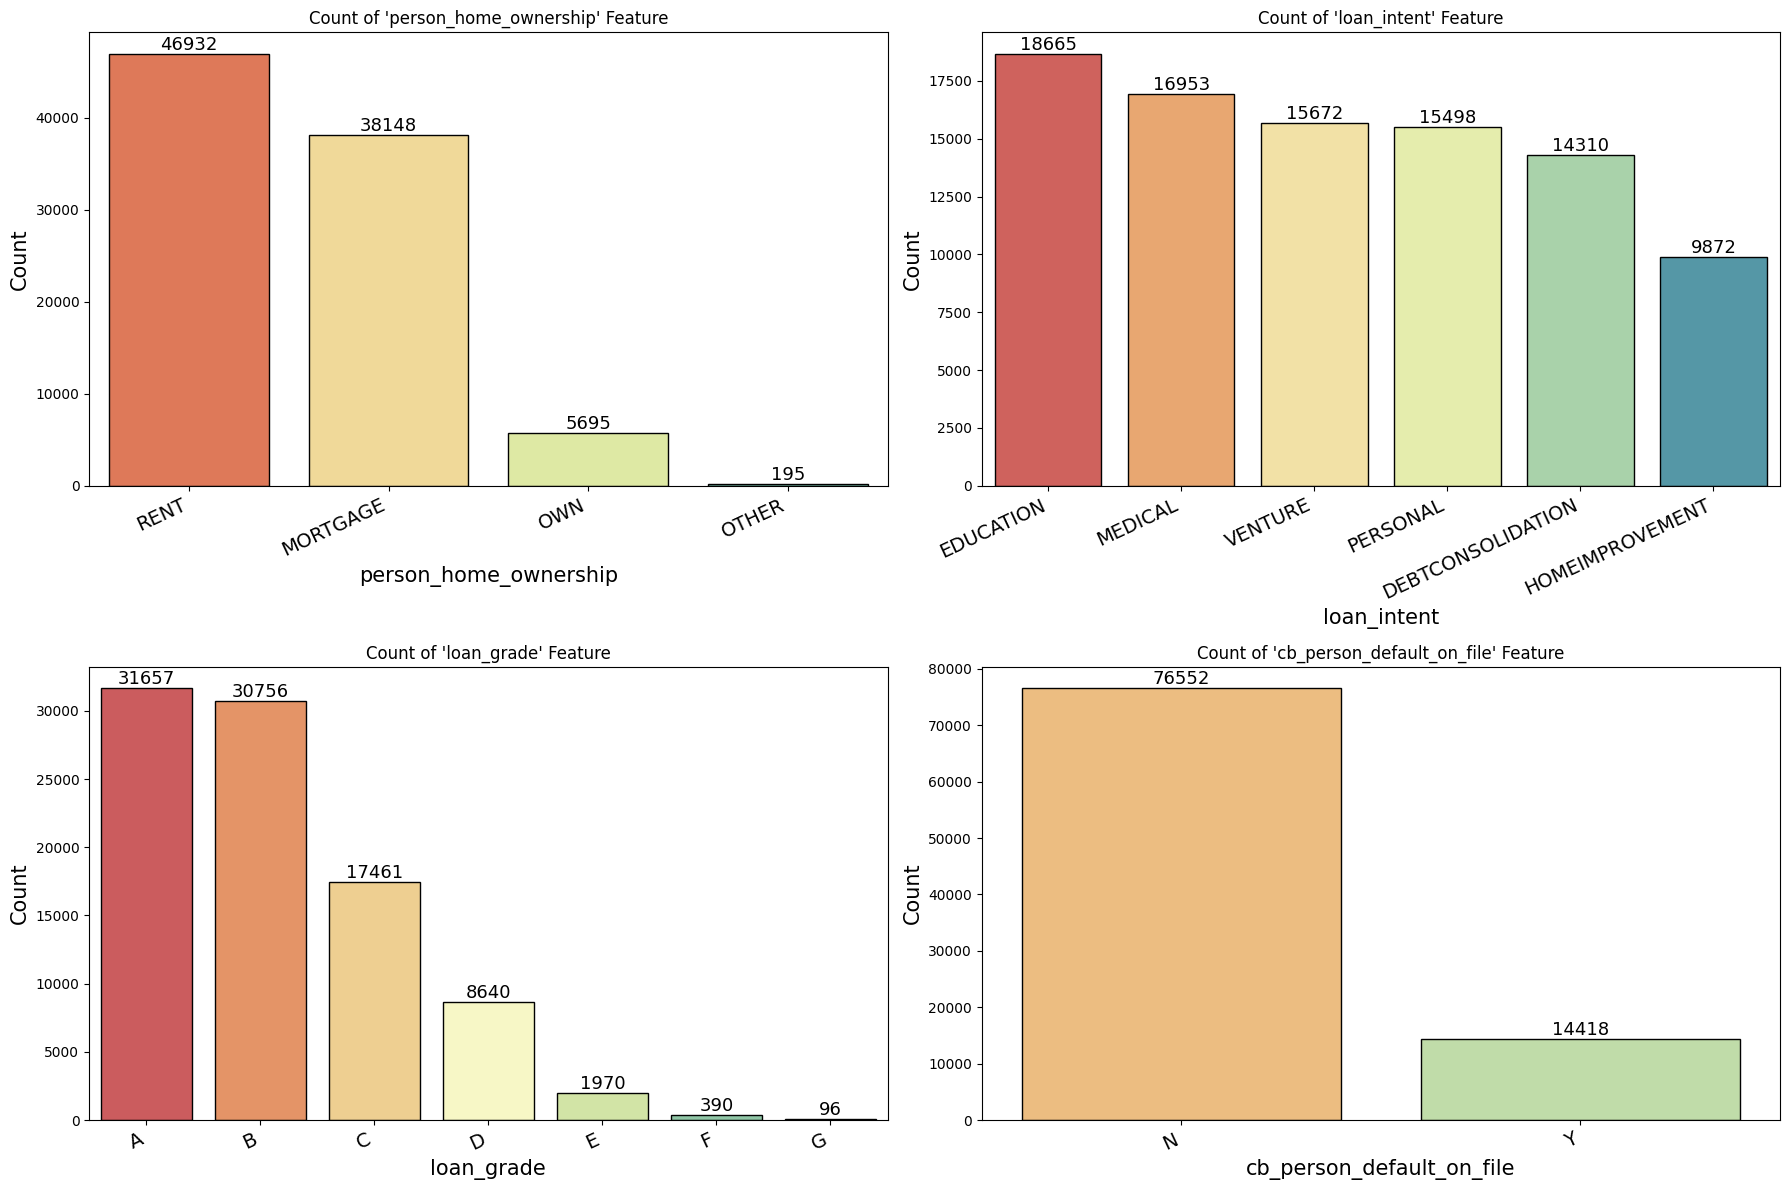

In [38]:
count_plot(data = df,
           features = categorical_features,
           size_x = 18,
           size_y = 12,
           padding = 0)

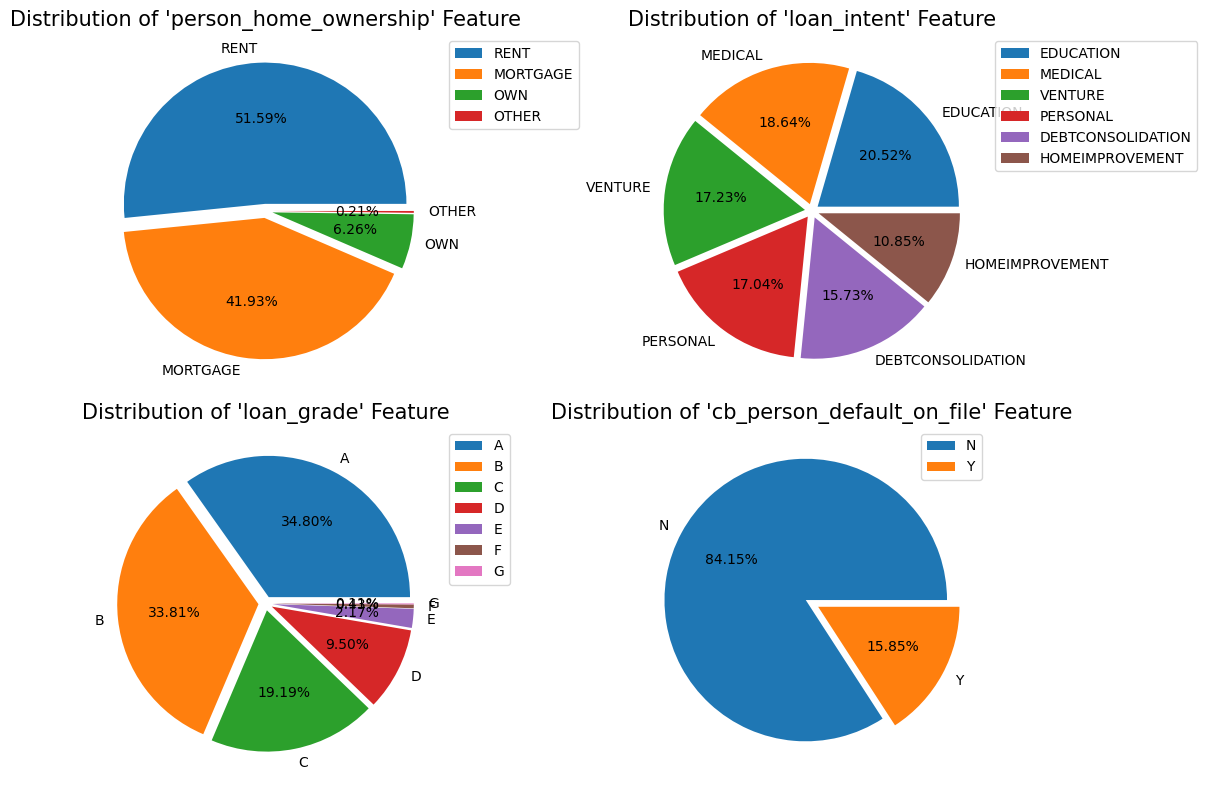

In [39]:
pie_plot(data = df,
         features = categorical_features,
         size_x = 12,
         size_y = 8,
         title_size = 15)

#### **5.2.1. & 5.2.2. Observations**

**`person_home_ownership`**
- **Renting** is the **most common** housing situation with **51.59%** of renters in the data. This suggests that a significant portion of individuals prefer renting, possibly due to financial constraints, job mobility, or local market conditions.
- **Mortgage** holders represent a larger share, that is, **41.93%** of people finance their homes through mortgages. This indicates strong home-buying activity, with many people committing to long-term ownership through financing rather than outright purchase.
- **Outright Homewoners** are relatively **few** with only **6.26%** of the total data. This low percentage may reflect the high cost of home ownership or a trend where fewer people purchase homes without loans.
- **Minimal** Presence of **Other** Home Ownership Types which stands merely at **0.21%** of the total. This category is negligible, potentially including unconventional ownership structures like cooperative housing or company-provided residences.

**`loan_intent`**
- **Education** leads the way as **20.52%** of total loans fall under this category. This suggests that a significant portion of loan applicants prioritize investing in education, possibly due to rising tuition costs or career advancement goals.
- **Medical** loans are common with a share of **18.64%** of the total. A considerable number of loans are for medical reasons, indicating potential gaps in healthcare coverage or emergency financial needs.
- **Personal** and **Venture** loans are similar in demand with around **17%** of the total data each. The similarity suggests that many individuals seek financial support either for personal needs or entrepreneurial ventures. This could reflect trends in small business financing and personal financial management.
- **Debt Consolidation** accounts for a notable share of **15.73%** of the total. This indicates that a significant portion of loan applicants are focused on managing existing debt, possibly to streamline payments or reduce interest rates.
- **Home Improvement** loans are the **least common** with **10.85%** of the total loans. While still relevant, home improvement loans form the smallest category, potentially indicating that fewer borrowers prioritize home upgrades compared to other financial needs.

**`loan_grade`**
- **High quality loans dominate**: Together, over **70%** of loans fall into **A** or **B**, indicating strong borrower creditworthiness and lower default risks. The dominance of A and B grades suggests the lender is dealing with relatively creditworthy borrowers, minimizing financial risk.
- **Mid-Tier loans (Grade C)** make up a significant share. This suggests a notable portion of borrowers with moderate credit risk—potentially balancing favorable interest rates and manageable risk.
- **Lower Grade loans** are **(D, E, F, G)** are relatively **rare**. These categories indicate higher risk, likely leading to higher interest rates or stricter approval conditions.

**`cb_person_default_on_file`**
- **Majority** have **no** default **(84.15% of the total)**. This suggests that most borrowers have maintained a strong financial record.
- A notable **minority** have **defaulted**. While smaller in proportion, this group represents a significant financial risk for lenders, as defaults can indicate past difficulties in meeting repayment obligations.

### **`5.2.3. Bivariate Analysis`**

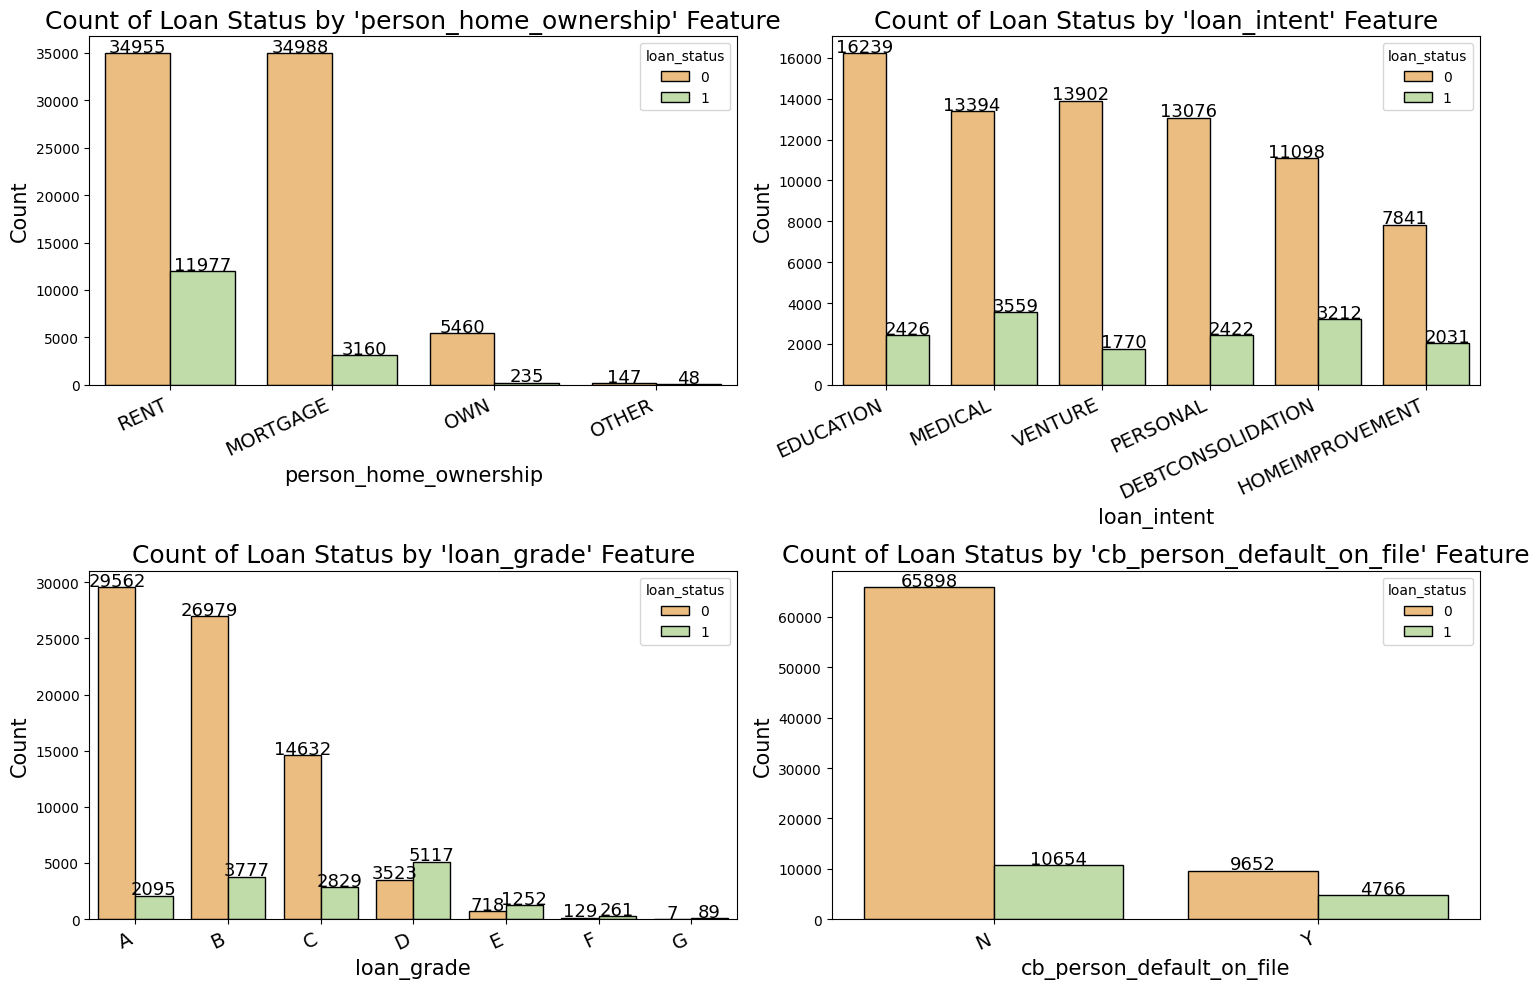

In [40]:
count_plot(data = df,
           features = categorical_features,
           target_col = 'loan_status',
           size_x = 15,
           size_y = 10,
           xlabel_size = 15,
           ylabel_size = 15,
           title_size = 18,
           padding = -2)

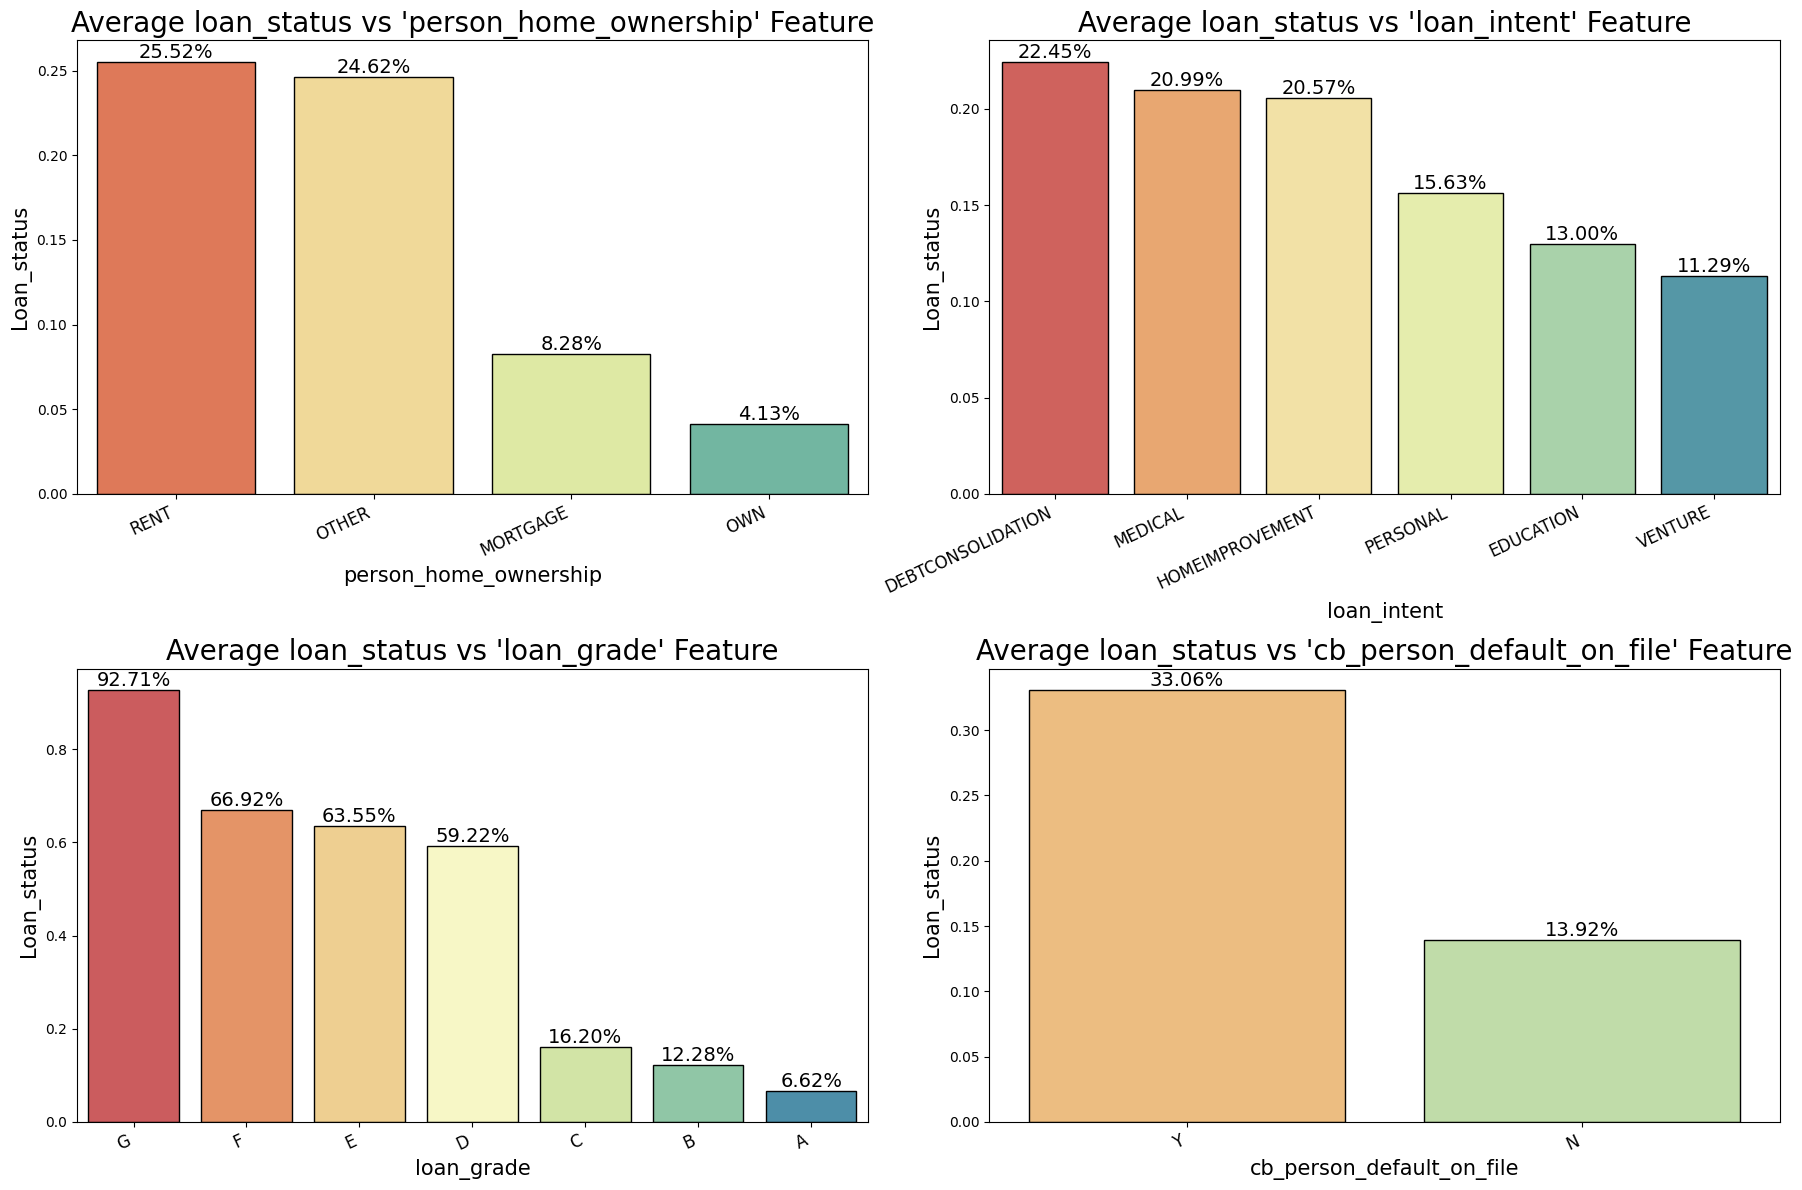

In [41]:
bivariate_plot(data = df,
               features = categorical_features,
               target = 'loan_status',
               size_x = 18,
               size_y = 12)

#### **5.2.3. Observations**

**`loan_status vs person_home_ownership`**
- Individuals who **own** their homes outright have the **lowest** approval rate of just **4.13%**. This may seem counterintuitive, but it is to note that they apply for **fewer** loans (only **6.26%** of the total loans) or are seen as **lower-risk** borrowers who don’t need financing. There is a chance that they may only apply for loans in specific cases where approval is harder.
- **Mortgage** holders have relatively **low** loan approval rates (around **8.28%**), possibly because they already have existing **financial obligations**, which could increase perceived risk.
- **Renters** see the **highest** loan approval rate among all groups (**25.52%**). This suggests they may be more likely to seek loans for financial flexibility.
- **Other** homeownership category shows **mid-range** approval rates, possibly reflecting varied financial backgrounds or alternative housing arrangements.

**`loan_status vs loan_intent`**
- **Debtconsolidation** loans have the **highest** approval rate of **22.45%**, possibly because lenders view them as structured financial solutions aimed at improving creditworthiness and repayment stability.
- **Medical** and **Home improvement** loans have moderate approval rates (around **21%**). These loans see similar trends, suggesting lenders may find them more viable than education or venture loans but still assess financial risk carefully.
- **Personal loans** are approved at **15.63%**. These loans typically lack clear repayment structures, which could lead to higher risk perception among lenders.
- **Education** and **Venture** loans have the **highest rejection** rates (**13% & 11.27% approval rates** respectively). This suggests that lenders might consider these loans high-risk, possibly due to uncertain future income for students or challenges in repayment for statups.

**`loan_status vs loan_grade`**
- Data suggests that **lower grade or high risk** individuals are **approved** at **higher** rates while **low risk** individuals are **rejected** at **higher** rates.

**`loan_status vs cb_person_default_on_file`**
- Nearly **33%** of borrowers with **past defaults** still get approved and surprisingly individuals **without defaults** face **more rejections**.

In [42]:
df = (
    df
    .assign(
        cb_person_default_on_file = lambda df_: df_['cb_person_default_on_file'].map({'N':0, 'Y':1})
    )
)
df.sample()

person_age  person_income person_home_ownership  person_emp_length  \
8812          22          95004              MORTGAGE                1.0   

     loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
8812    PERSONAL          A       7200           9.63                 0.08   

      cb_person_default_on_file  cb_person_cred_hist_length  loan_status  
8812                          0                           2            0

### **`5.2.4. Multivariate Analysis`**

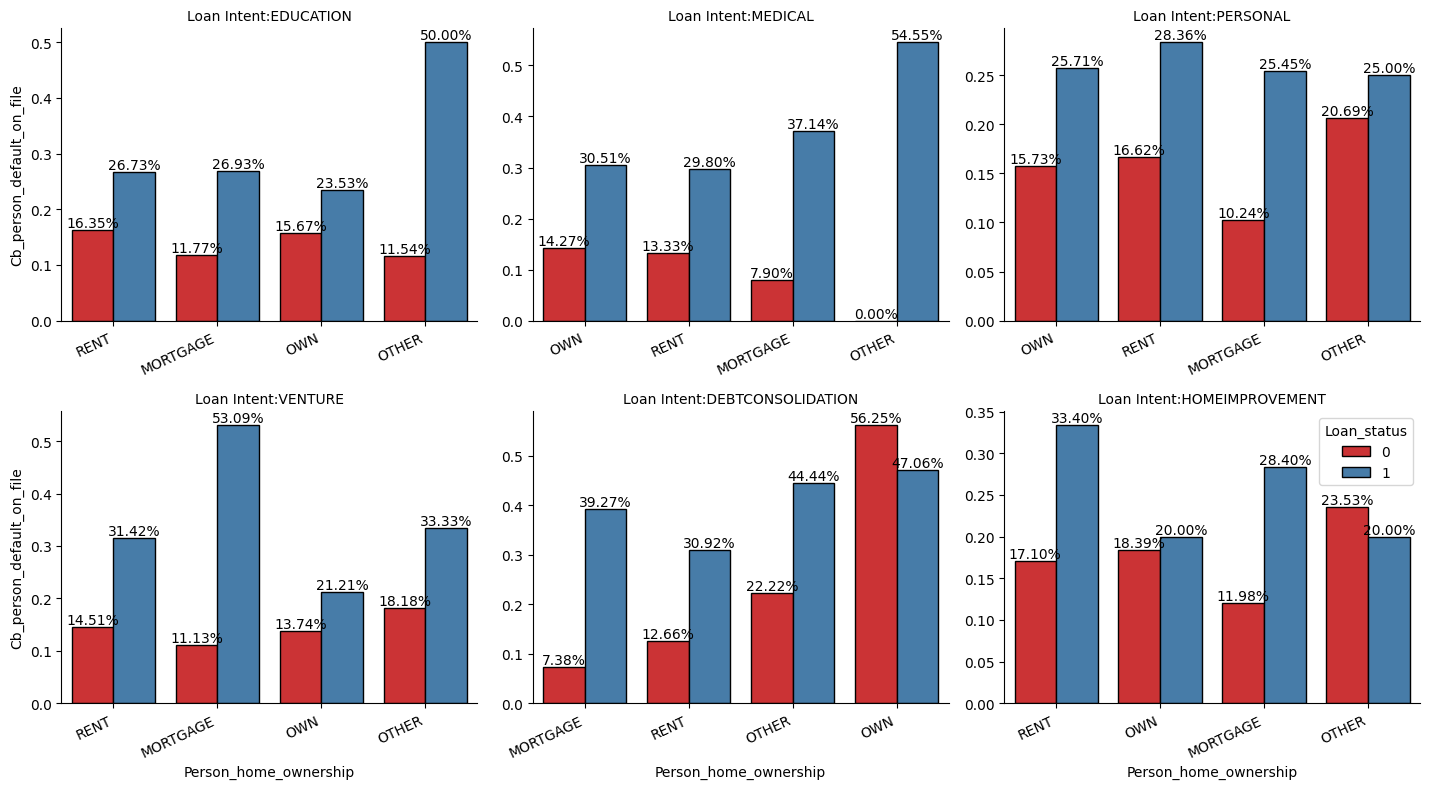

In [43]:
multivariate_plot(data = df,
                  col = 'loan_intent',
                  x = 'person_home_ownership',
                  y = 'cb_person_default_on_file',
                  hue = 'loan_status',
                  title_template = 'Loan Intent:{col_name}')

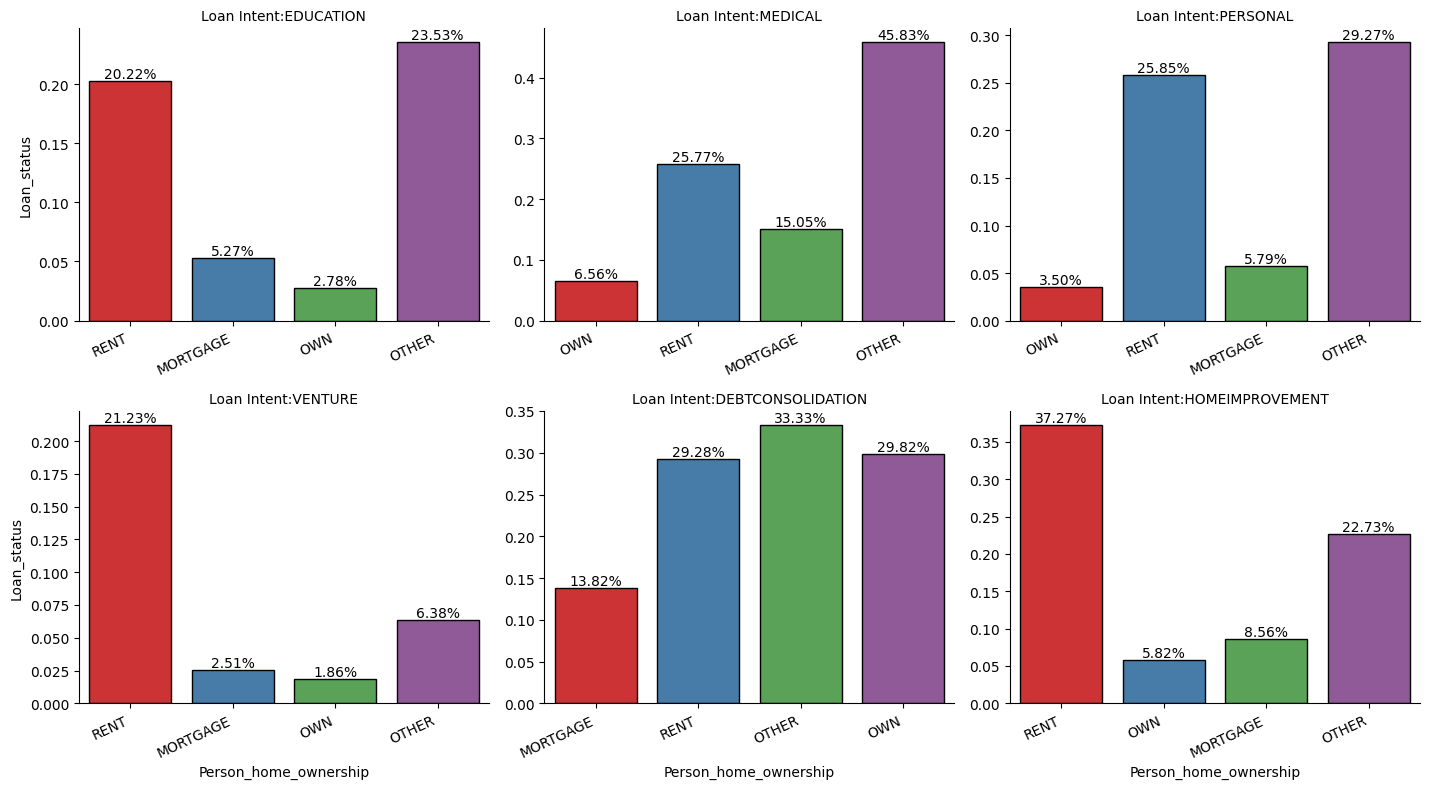

In [44]:
multivariate_plot(data = df,
                  col = 'loan_intent',
                  x = 'person_home_ownership',
                  y = 'loan_status',
                  title_template = 'Loan Intent:{col_name}')

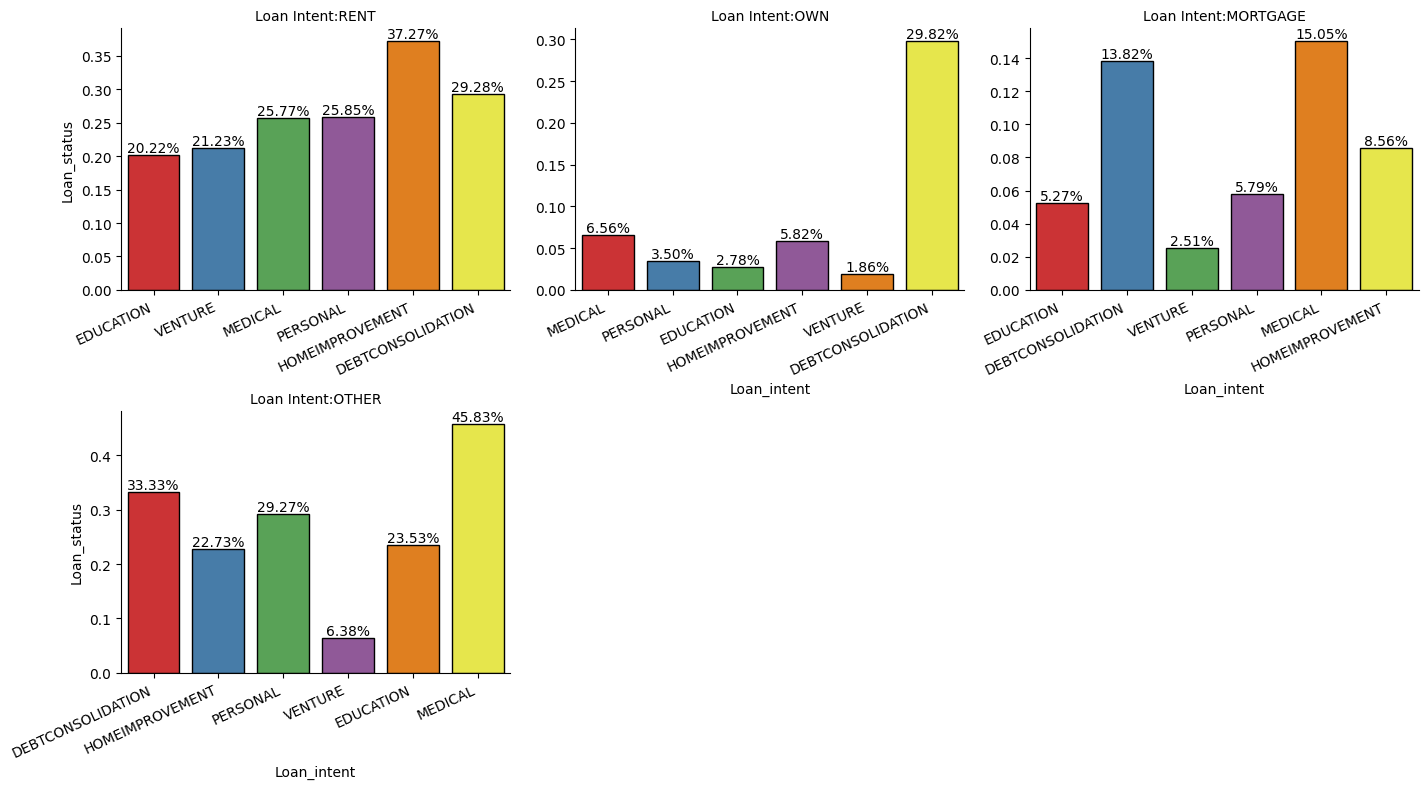

In [45]:
multivariate_plot(data = df,
                  col = 'person_home_ownership',
                  x = 'loan_intent',
                  y = 'loan_status',
                  title_template = 'Loan Intent:{col_name}')

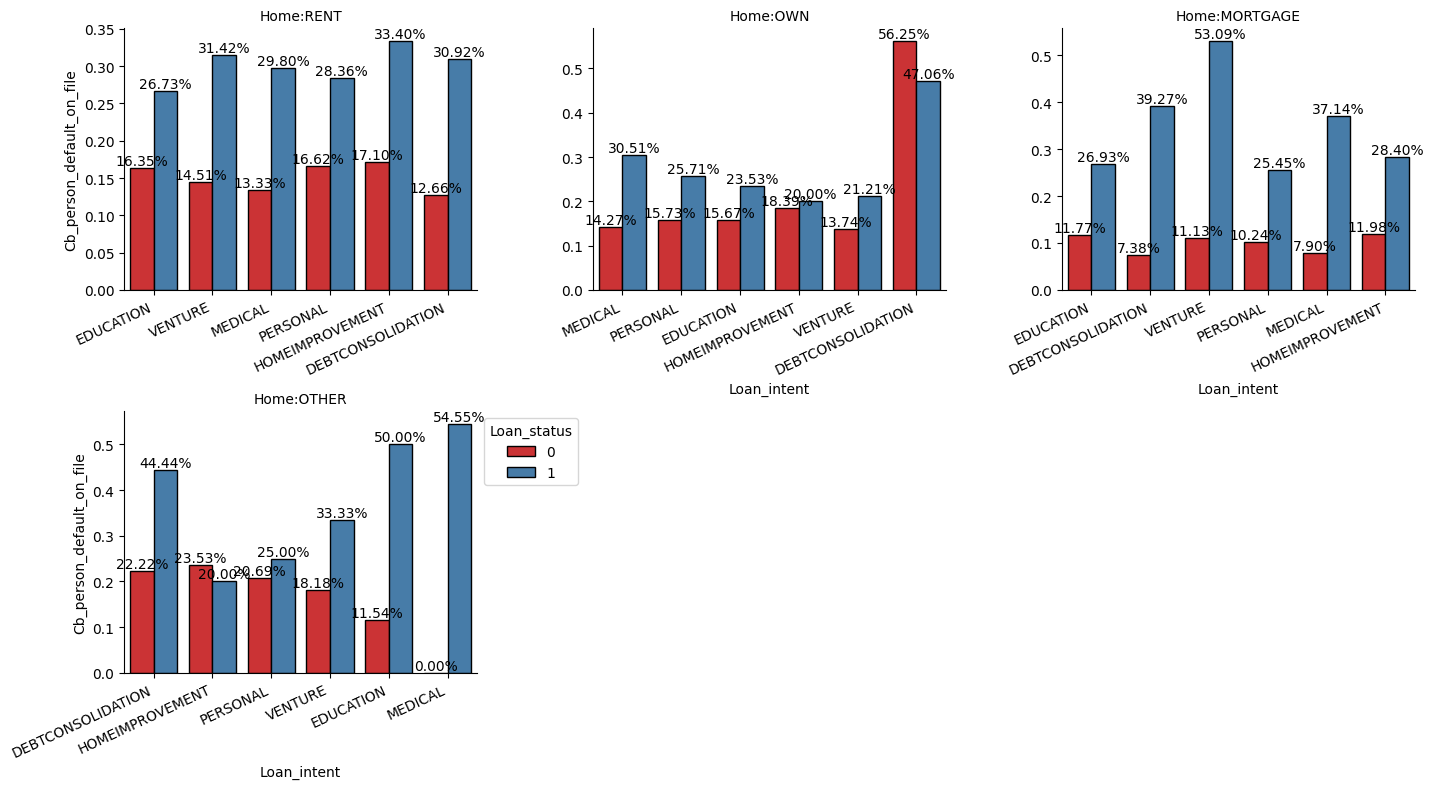

In [46]:
multivariate_plot(data = df,
                  col = 'person_home_ownership',
                  x = 'loan_intent',
                  y = 'cb_person_default_on_file',
                  hue = 'loan_status',
                  title_template = 'Home:{col_name}')

## **`5.3. EDA - Numerical Features`**

### **`5.3.1. Basic Descriptive Stats`**

In [47]:
(
    df[numerical_features]
    .describe()
    .T
)

count          mean           std      min  \
person_age                  90970.0     27.614928      6.089402    20.00   
person_income               90970.0  64699.072826  43699.624245  4000.00   
person_emp_length           90970.0      4.713807      3.917094     0.00   
loan_amnt                   90970.0   9349.358327   5845.427933   500.00   
loan_int_rate               90970.0     10.796170      3.055830     5.42   
loan_percent_income         90970.0      0.163147      0.097469     0.00   
cb_person_cred_hist_length  90970.0      5.811476      4.038080     2.00   
loan_status                 90970.0      0.169506      0.375201     0.00   

                                 25%       50%       75%         max  
person_age                     23.00     26.00     30.00       94.00  
person_income               40000.00  57000.00  78000.00  2039784.00  
person_emp_length               2.00      4.00      7.00       41.00  
loan_amnt                    5000.00   8000.00  12000.00    35000.00  
loan_int_rate                   7.88     10.95     13.04       23.22  
loan_percent_income             0.09      0.14      0.22        0.83  
cb_person_cred_hist_length      3.00      4.00      8.00       30.00  
loan_status                     0.00      0.00      0.00        1.00

In [48]:
discrete_num_features = ['person_emp_length', 'cb_person_cred_hist_length']
continuous_num_features = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate', 'loan_percent_income']

### **`5.3.2. Univariate Analysis`**
#### Discrete Numerical Features

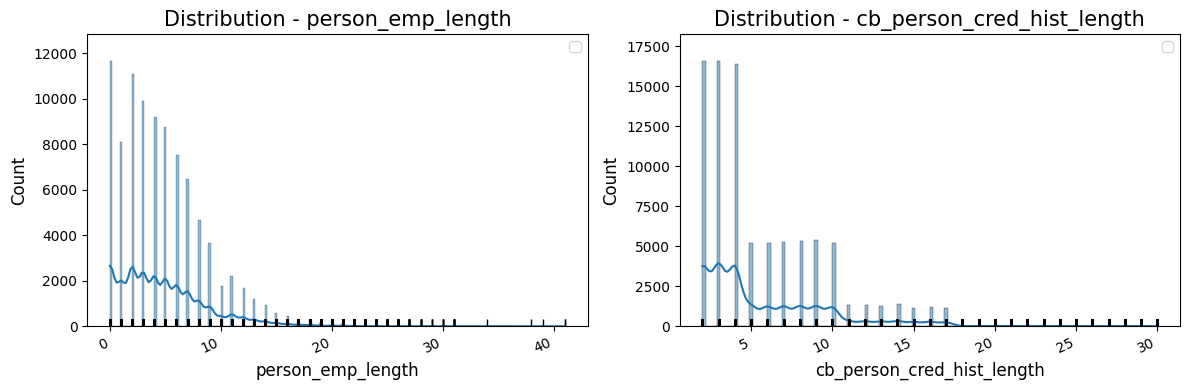

In [49]:
hist_plot(data = df,
          features = discrete_num_features,
          size_x = 12,
          size_y = 4)

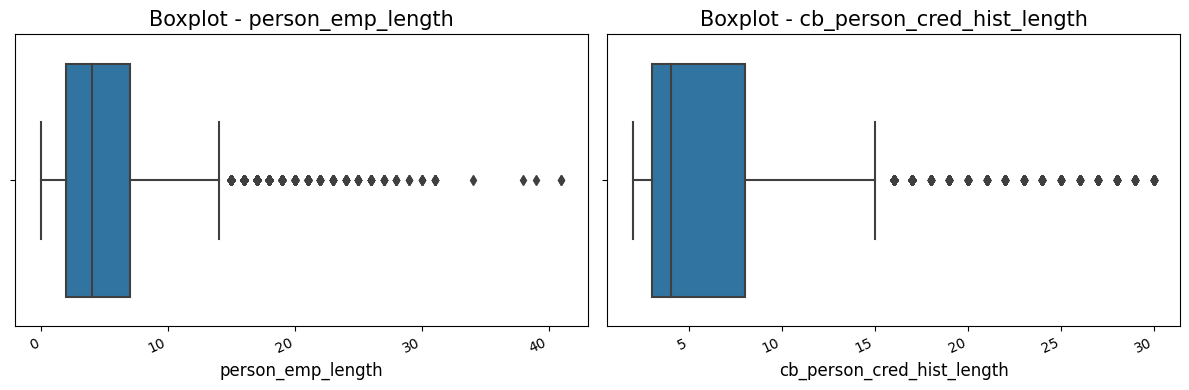

In [50]:
box_plot(data = df,
         features = discrete_num_features,
         size_x = 12,
         size_y = 4)

In [51]:
df[df['cb_person_cred_hist_length'] > 15]['loan_status'].value_counts()

loan_status
0    2567
1     558
Name: count, dtype: int64

#### Continuous Numerical Features

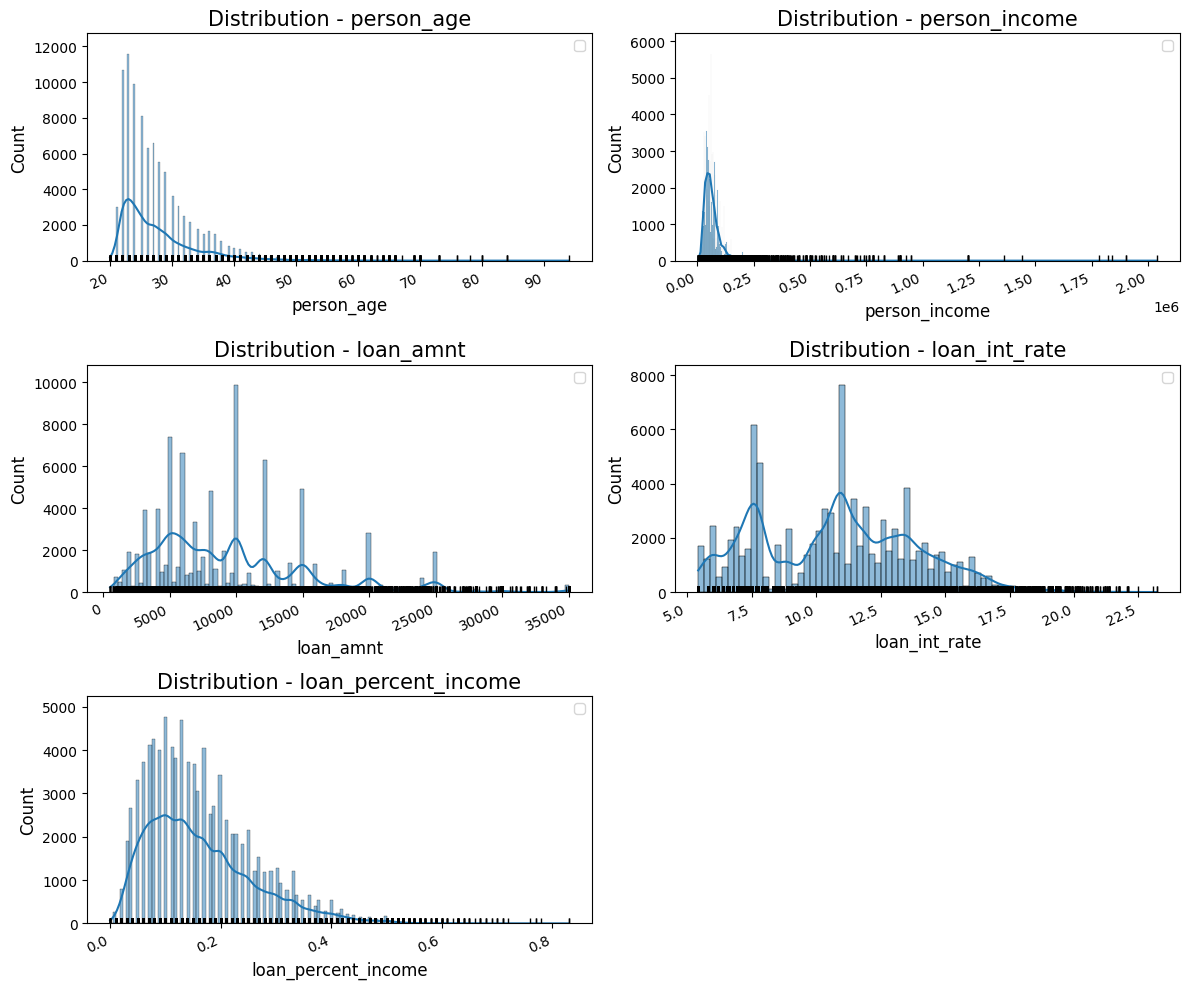

In [52]:
hist_plot(data = df,
          features = continuous_num_features,
          size_x = 12,
          size_y = 10)

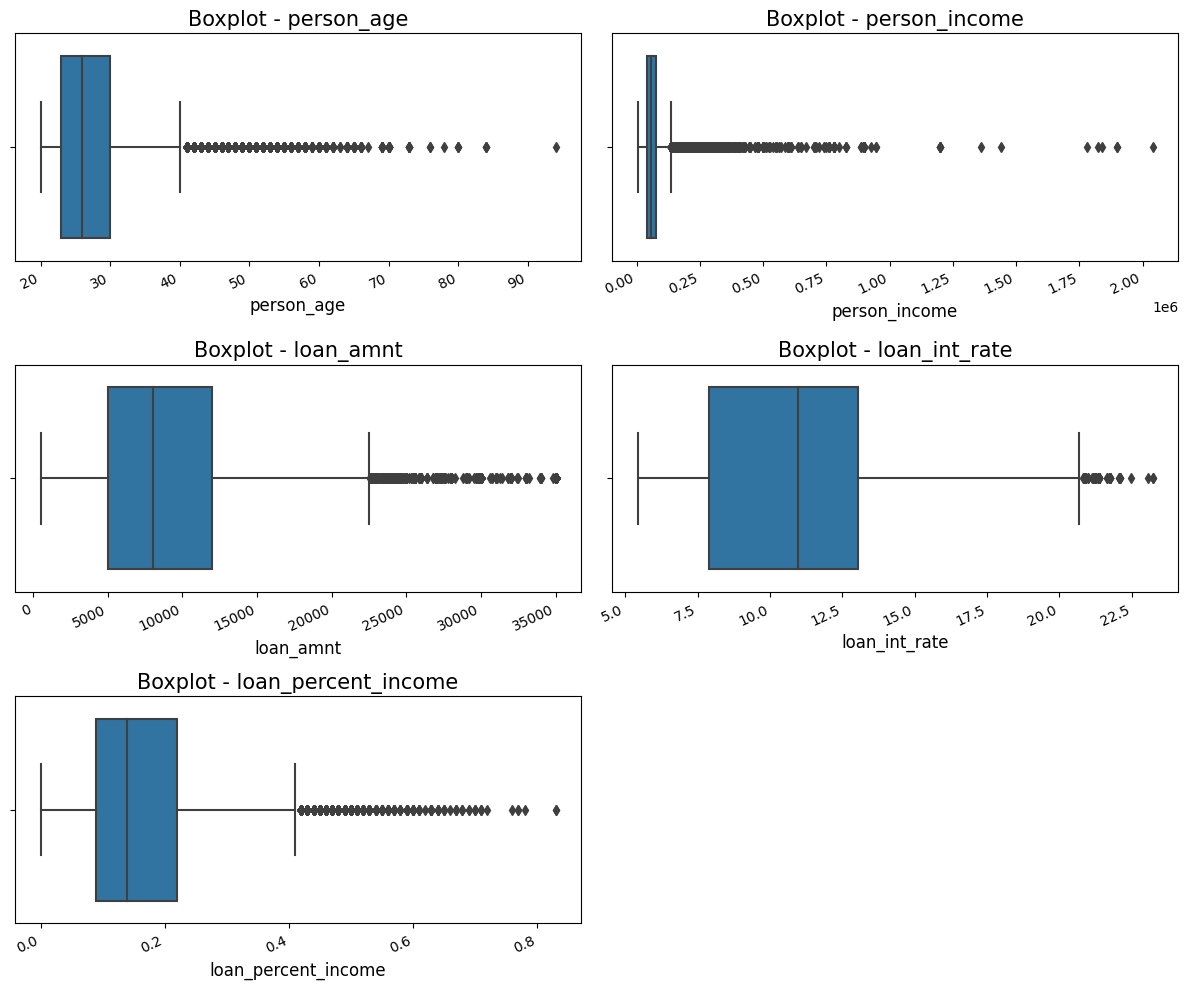

In [53]:
box_plot(data = df,
         features = continuous_num_features,
         size_x = 12,
         size_y = 10)

### **`5.3.3. Bivariate Analysis`**

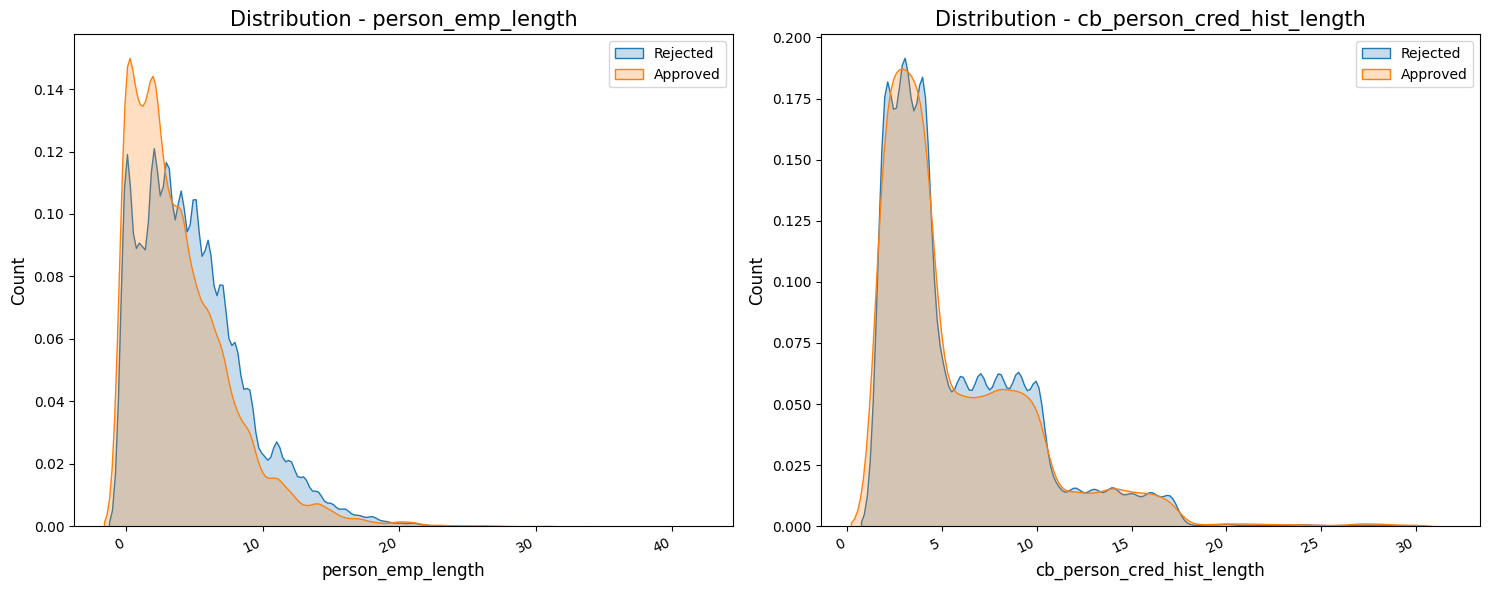

In [54]:
hist_plot(data = df,
         features = discrete_num_features,
         hue = 'loan_status',
         size_x = 15,
         size_y = 6)

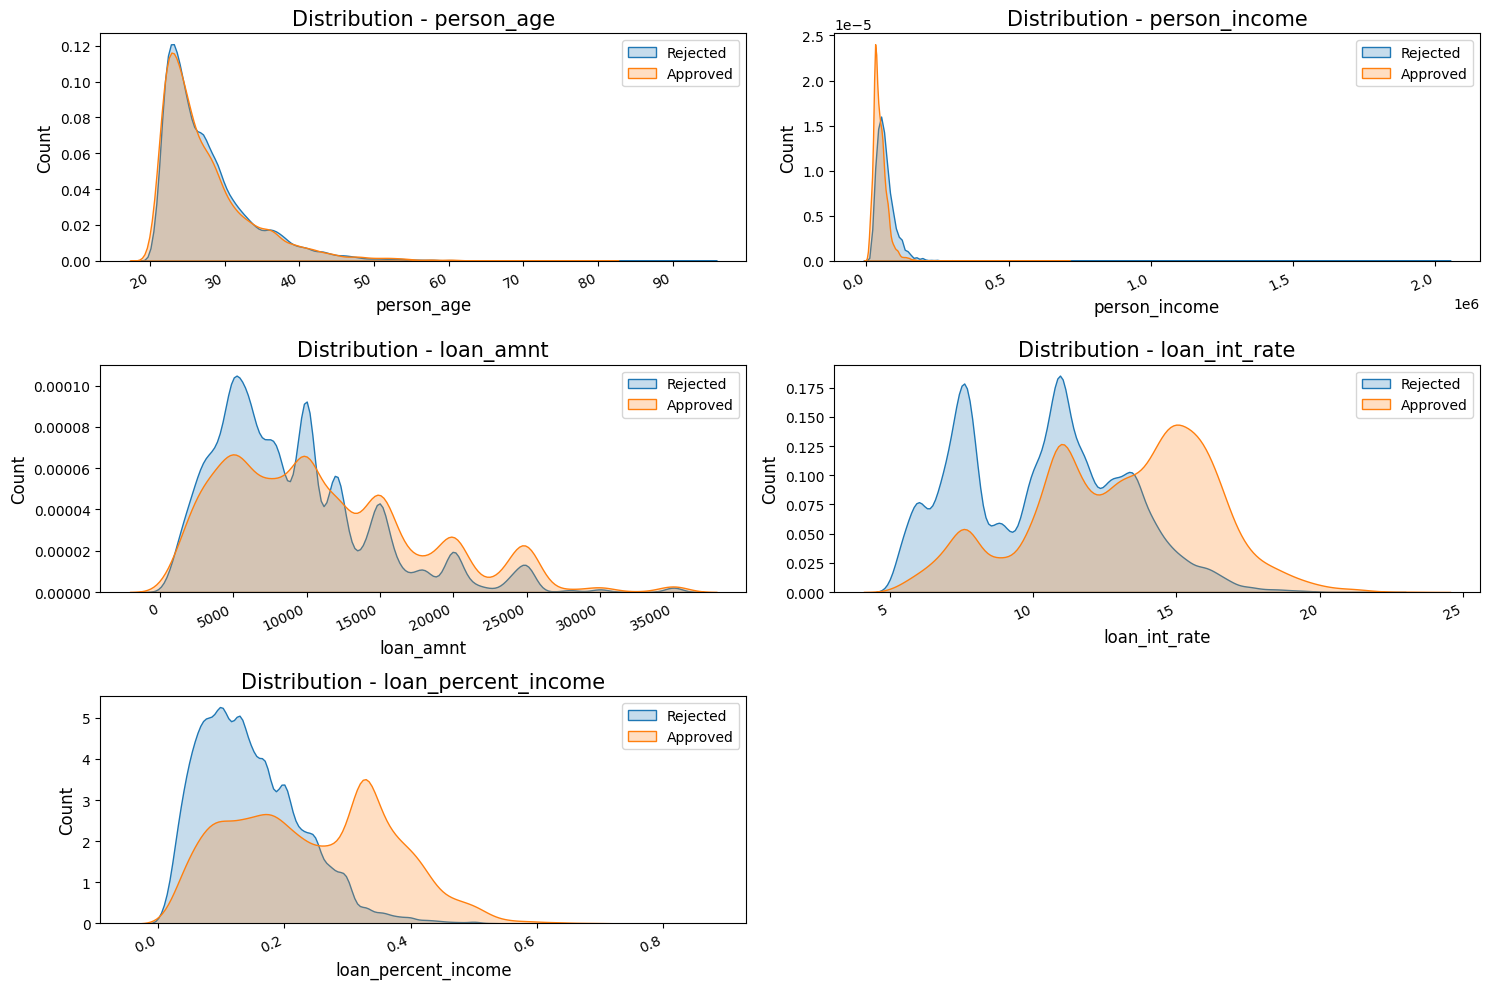

In [55]:
hist_plot(data = df,
         features = continuous_num_features,
         hue = 'loan_status',
         size_x = 15,
         size_y = 10)

### **`5.3.4. Multivariate Analysis`**

<Figure size 1000x600 with 0 Axes>

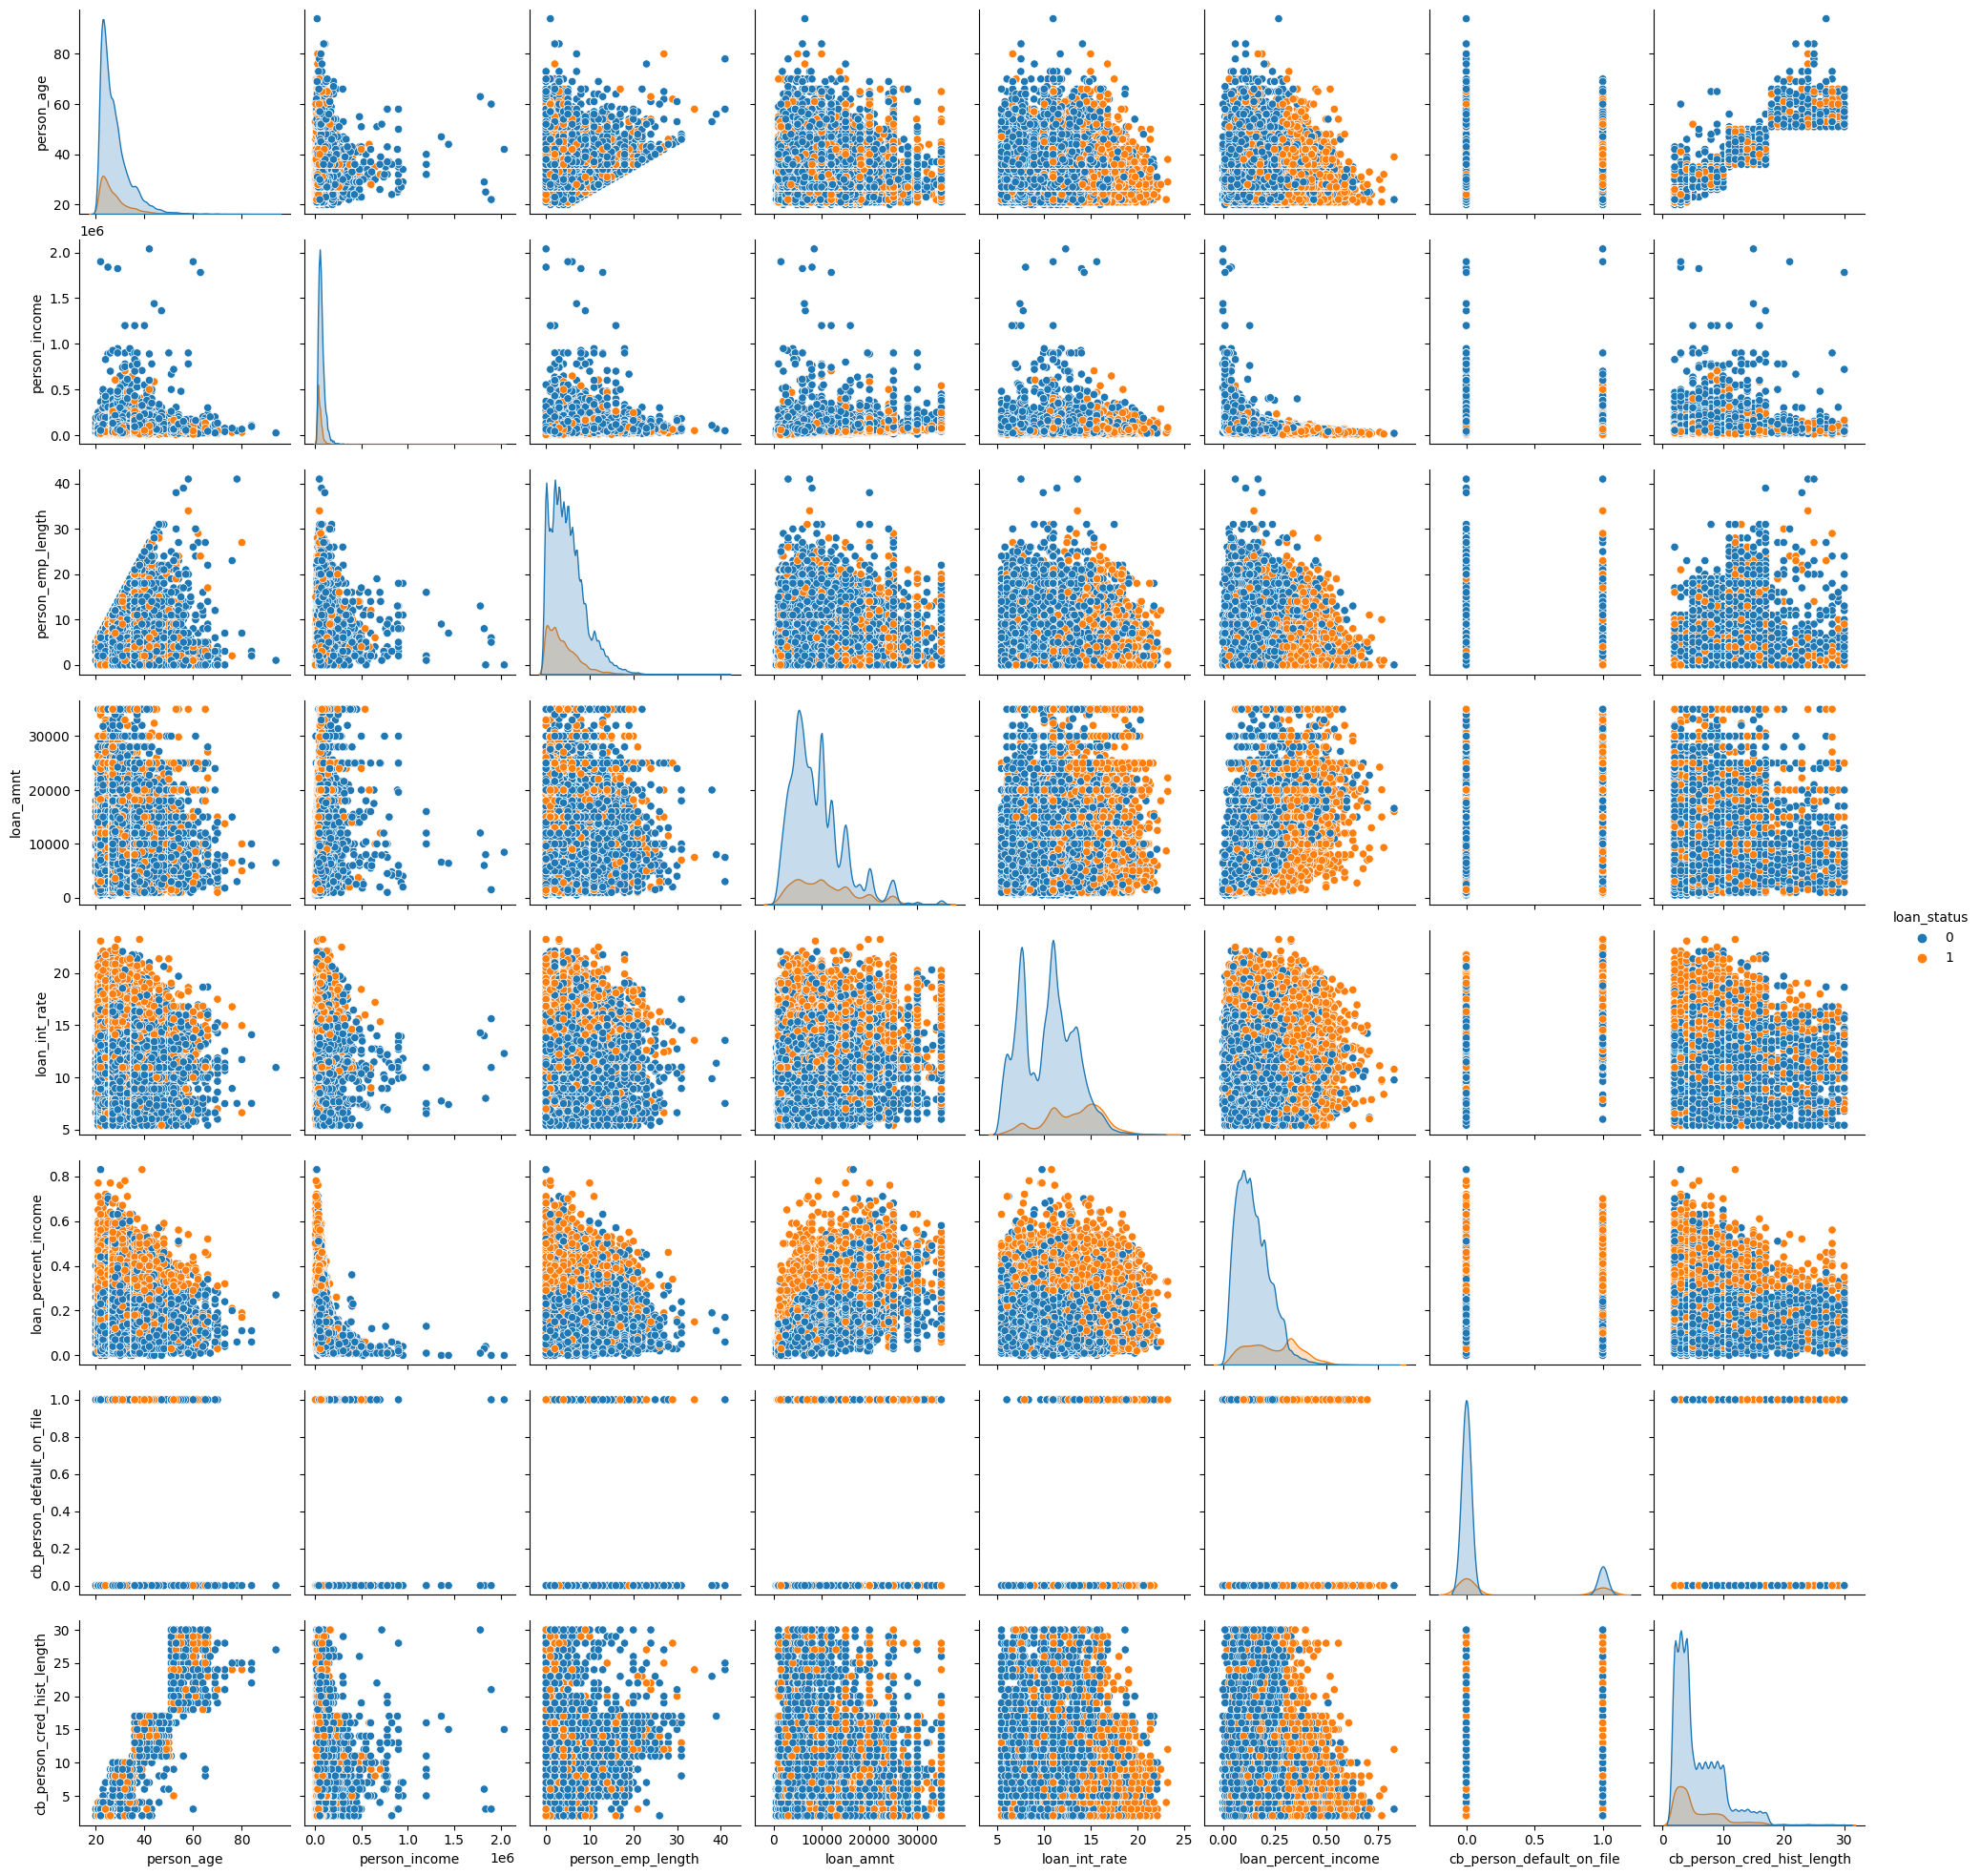

In [56]:
plt.figure(figsize = (10,6))
sns.pairplot(data = df, hue = 'loan_status')
plt.show()

# **`6. Correlation Analysis`**
## **`8.1. Correlation of Independent Features`**

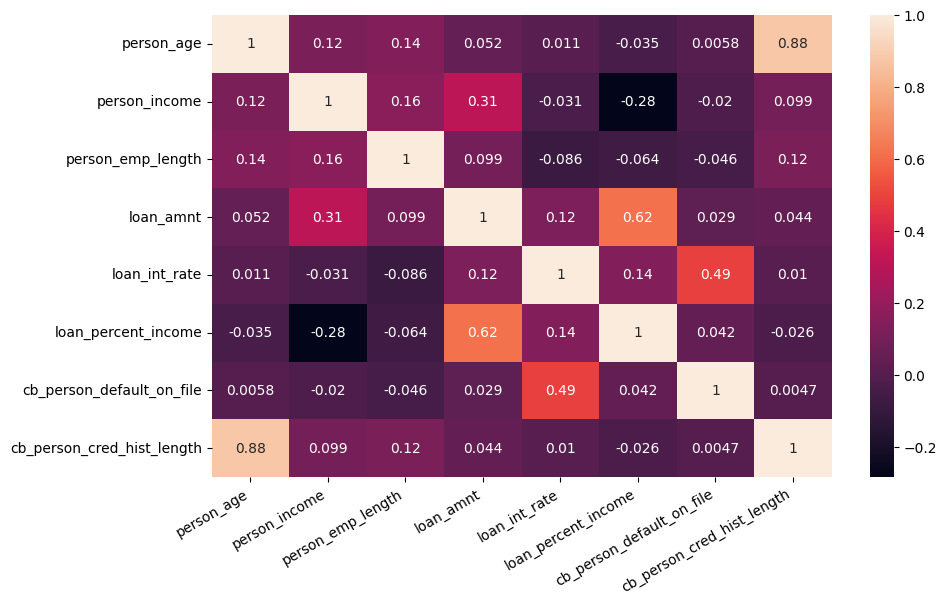

In [57]:
plt.figure(figsize = (10,6))
sns.heatmap(df.drop(columns = ['loan_status']).corr(numeric_only = True), annot = True)
plt.xticks(rotation = 30, ha = 'right')
plt.show()

## **`8.2. Correlation of Numeric Features with Target Feature`**

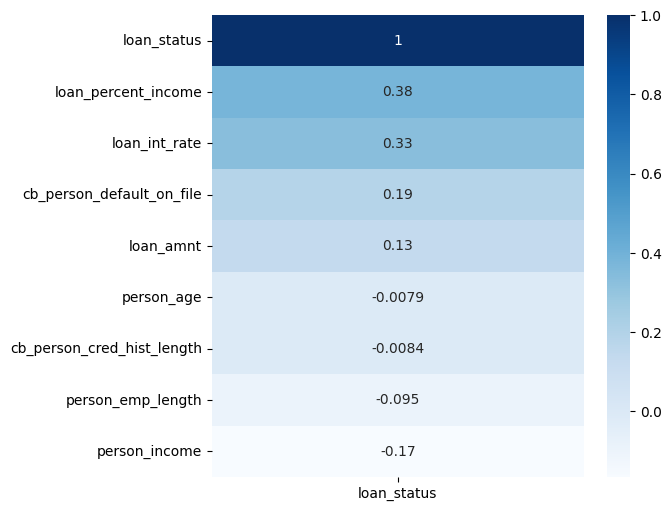

In [58]:
plt.figure(figsize = (6,6))
(
   sns.heatmap(df.corr(numeric_only = True)
               [['loan_status']].sort_values('loan_status', ascending = False), 
               annot = True, cmap = 'Blues')
)
plt.show()

# **`7. Data Preparation`**
## **`7.1. Separating Independent Variables and Dependent Variable`**

In [59]:
X = df.drop('loan_status', axis = 1)
y = df['loan_status']

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (90970, 11)
Shape of y: (90970,)


## **`7.2. Splitting Data into Train, Validation Sets`**

In [60]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3,
                                                  random_state = 2, stratify = y)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

print(f"\nTraining Set (y_train):")
print(y_train.value_counts(normalize=True)*100)
print(f"\nValidation Set (y_val):")
print(y_val.value_counts(normalize=True)*100)

X_train shape: (63679, 11)
X_val shape: (27291, 11)
y_train shape: (63679,)
y_val shape: (27291,)

Training Set (y_train):
loan_status
0    83.049357
1    16.950643
Name: proportion, dtype: float64

Validation Set (y_val):
loan_status
0    83.049357
1    16.950643
Name: proportion, dtype: float64


## **`7.3. Data Preprocessing`**

In [61]:
map_loan_grade = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}

X_train = (
    X_train
    .assign(
        loan_grade = lambda df_: df_['loan_grade'].map(map_loan_grade)
    )
)

X_val = (
    X_val
    .assign(
        loan_grade = lambda df_: df_['loan_grade'].map(map_loan_grade)
    )
)

In [62]:
preprocessor = ColumnTransformer(transformers = [
    ('nominal', OneHotEncoder(sparse_output = False, drop = 'first'), [2, 4]),
    ('numerical', StandardScaler(), [0,1,3,5,6,7,8,9,10])
], remainder = 'passthrough')

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)

nominal_col = preprocessor.transformers_[0][1].get_feature_names_out()
numerical_col = preprocessor.transformers_[1][1].get_feature_names_out()
cols = list(nominal_col) + list(numerical_col)

X_train_df = pd.DataFrame(data = X_train, columns = cols)
X_val_df = pd.DataFrame(data = X_val, columns = cols)

# **`10. Model Building`**

In [63]:
def model_evaluate(clf, train_X, train_y, test_X, test_y, target_precision = None):
    clf.fit(train_X, train_y)
    
    y_pred_train = clf.predict(train_X)
    y_pred_test = clf.predict(test_X)
    y_probs_test = clf.predict_proba(test_X)[:, 1]
    y_probs_train = clf.predict_proba(train_X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(test_y, y_probs_test)

    if target_precision != None:
        target_precision = target_precision
        idx = np.argmax(precision >= target_precision)
        chosen_threshold = thresholds[idx]
    
        y_pred_custom = (y_probs_test >= chosen_threshold).astype(int)
        train_accuracy = accuracy_score(train_y, y_pred_train)
        test_accuracy = accuracy_score(test_y, y_pred_custom)
        roc_auc_train = roc_auc_score(train_y, y_probs_train)
        roc_auc_test = roc_auc_score(test_y, y_pred_custom)

        print(f"Selected Threshold: {chosen_threshold:0.3f}")
        print('-'*55)
        print(f"Train Accuracy: {train_accuracy:0.3f}")
        print(f"Test Accuracy: {test_accuracy:0.3f}")
        print('-'*55)
        print(f"Train ROC-AUC Score: {roc_auc_train:.3f}")
        print(f"Test ROC-AUC Score: {roc_auc_test:.3f}")

        print('-'*55)
        print(f"\n Classification Report:\n {classification_report(test_y, y_pred_custom)}")
        print('-'*55)
        
        cm = confusion_matrix(test_y, y_pred_custom)
        cmd = ConfusionMatrixDisplay(cm)
        cmd.plot()
        plt.title('Confusion Matrix')
        plt.xticks([0,1],['Rejected', 'Approved'])
        plt.yticks([0,1],['Rejected', 'Approved'])
        plt.show()

    else:
        train_accuracy = accuracy_score(train_y, y_pred_train)
        test_accuracy = accuracy_score(test_y, y_pred_test)
        roc_auc_train = roc_auc_score(train_y, y_probs_train)
        roc_auc_test = roc_auc_score(test_y, y_probs_test)
    
        print(f"Selected Threshold: 0.50")
        print('-'*55)
        print(f"Train Accuracy: {train_accuracy:0.3f}")
        print(f"Test Accuracy: {test_accuracy:0.3f}")
        print('-'*55)
        print(f"Train ROC-AUC Score: {roc_auc_train:.3f}")
        print(f"Test ROC-AUC Score: {roc_auc_test:.3f}")
        
        print('-'*55)
        print(f"\n Classification Report:\n {classification_report(test_y, y_pred_test)}")
        print('-'*55)
        
        cm = confusion_matrix(test_y, y_pred_test)
        cmd = ConfusionMatrixDisplay(cm)
        cmd.plot()
        plt.title('Confusion Matrix')
        plt.xticks([0,1],['Rejected', 'Approved'])
        plt.yticks([0,1],['Rejected', 'Approved'])
        plt.show()

## **`10.1. Logistic Regression`**

Logistic Regression Summary:

Selected Threshold: 0.50
-------------------------------------------------------
Train Accuracy: 0.884
Test Accuracy: 0.882
-------------------------------------------------------
Train ROC-AUC Score: 0.881
Test ROC-AUC Score: 0.879
-------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93     22665
           1       0.74      0.47      0.57      4626

    accuracy                           0.88     27291
   macro avg       0.82      0.72      0.75     27291
weighted avg       0.87      0.88      0.87     27291

-------------------------------------------------------


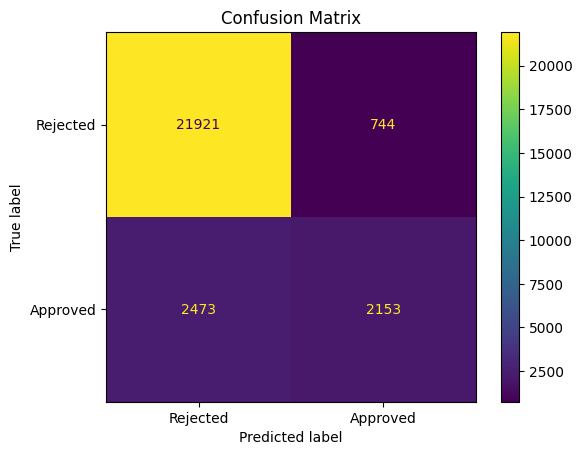

In [64]:
lr = LogisticRegression()
print("Logistic Regression Summary:\n")
model_evaluate(lr, X_train, y_train, X_val, y_val)

## **`10.2. Decision Tree`**

Decision Tree Summary:

Selected Threshold: 0.50
-------------------------------------------------------
Train Accuracy: 1.000
Test Accuracy: 0.909
-------------------------------------------------------
Train ROC-AUC Score: 1.000
Test ROC-AUC Score: 0.845
-------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94     22665
           1       0.72      0.75      0.74      4626

    accuracy                           0.91     27291
   macro avg       0.84      0.85      0.84     27291
weighted avg       0.91      0.91      0.91     27291

-------------------------------------------------------


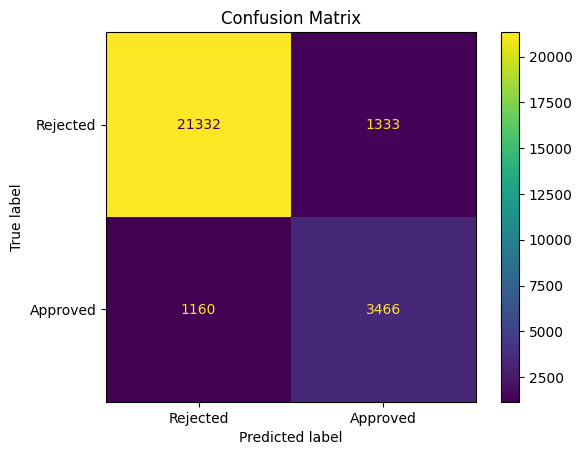

In [65]:
dt = DecisionTreeClassifier()
print("Decision Tree Summary:\n")
model_evaluate(dt, X_train, y_train, X_val, y_val)

## **`10.3. Random Forest`**

Random Forest Summary:

Selected Threshold: 0.50
-------------------------------------------------------
Train Accuracy: 1.000
Test Accuracy: 0.947
-------------------------------------------------------
Train ROC-AUC Score: 1.000
Test ROC-AUC Score: 0.939
-------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     22665
           1       0.95      0.73      0.82      4626

    accuracy                           0.95     27291
   macro avg       0.95      0.86      0.90     27291
weighted avg       0.95      0.95      0.94     27291

-------------------------------------------------------


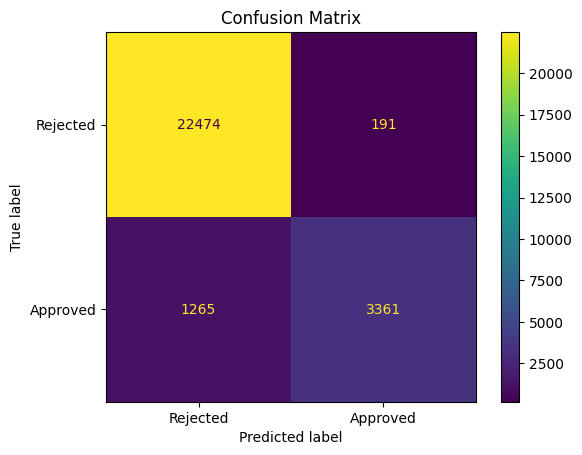

In [66]:
rfc = RandomForestClassifier()
print("Random Forest Summary:\n")
model_evaluate(rfc, X_train_df, y_train, X_val_df, y_val)

### **`Tuned Random Forest`**

Random Forest (Tuned) Summary:

Selected Threshold: 0.50
-------------------------------------------------------
Train Accuracy: 0.959
Test Accuracy: 0.947
-------------------------------------------------------
Train ROC-AUC Score: 0.988
Test ROC-AUC Score: 0.940
-------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     22665
           1       0.95      0.72      0.82      4626

    accuracy                           0.95     27291
   macro avg       0.95      0.86      0.90     27291
weighted avg       0.95      0.95      0.94     27291

-------------------------------------------------------


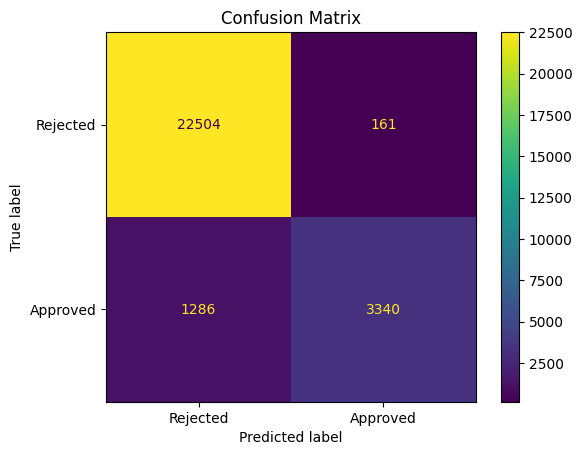

In [67]:
rfc_tuned = RandomForestClassifier(max_depth = 15)
print("Random Forest (Tuned) Summary:\n")
model_evaluate(rfc_tuned, X_train_df, y_train, X_val_df, y_val)

## **`10.4. Gradient Boosting`**

Gradient Boosting Summary:

Selected Threshold: 0.50
-------------------------------------------------------
Train Accuracy: 0.938
Test Accuracy: 0.940
-------------------------------------------------------
Train ROC-AUC Score: 0.937
Test ROC-AUC Score: 0.935
-------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     22665
           1       0.92      0.71      0.80      4626

    accuracy                           0.94     27291
   macro avg       0.93      0.85      0.88     27291
weighted avg       0.94      0.94      0.94     27291

-------------------------------------------------------


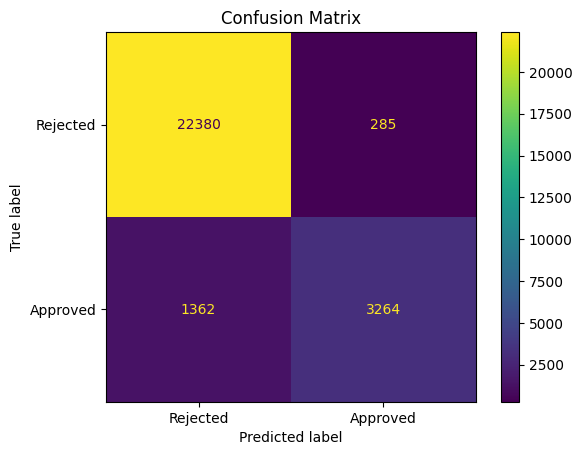

In [68]:
gb = GradientBoostingClassifier()
print("Gradient Boosting Summary:\n")
model_evaluate(gb, X_train_df, y_train, X_val_df, y_val)

## **`10.5. XGBoost`**

XGBoost Summary:

Selected Threshold: 0.50
-------------------------------------------------------
Train Accuracy: 0.956
Test Accuracy: 0.948
-------------------------------------------------------
Train ROC-AUC Score: 0.980
Test ROC-AUC Score: 0.954
-------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     22665
           1       0.94      0.75      0.83      4626

    accuracy                           0.95     27291
   macro avg       0.94      0.87      0.90     27291
weighted avg       0.95      0.95      0.95     27291

-------------------------------------------------------


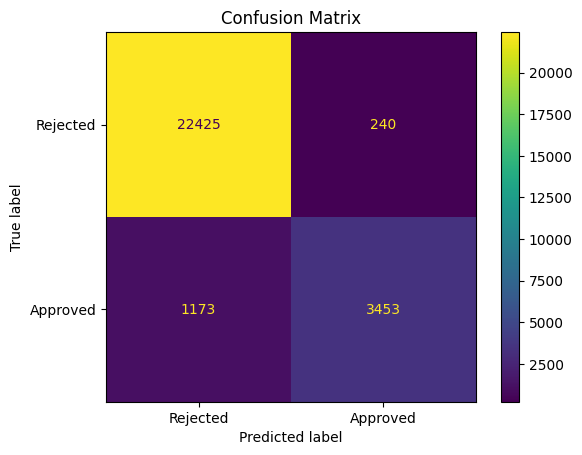

In [69]:
xgb = XGBClassifier()
print("XGBoost Summary:\n")
model_evaluate(xgb, X_train_df, y_train, X_val_df, y_val)

# **`11. Model Comparison & Selection`**

In [70]:
model = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost']
precision_class0 = [0.90, 0.95, 0.95, 0.94, 0.95]
precision_class1 = [0.74, 0.72, .95, 0.92, 0.94]
recall_class0 = [0.97, 0.94, 0.99, 0.99, 0.99]
recall_class1 = [0.47, 0.75, 0.72, 0.71, 0.75]
f1_class0 = [0.93, 0.94, 0.97, 0.96, 0.97]
f1_class1 = [0.57, 0.74, 0.82, 0.80, 0.83]
train_accuracy = [0.884, 1.000, 0.960, 0.938, 0.956]
test_accuracy = [0.882, 0.909, 0.947, 0.940, 0.948]
train_roc_auc = [0.881, 1.000, 0.987, 0.937, 0.980]
test_roc_auc = [0.879, 0.846, 0.939, 0.935, 0.954]

evaluation_comparison = pd.DataFrame(data = {'Model': model,
                                             'Accuracy(Train)': train_accuracy,
                                             'Accuracy(Test)': test_accuracy,
                                             'ROC-AUC (Train)': train_roc_auc, 
                                             'ROC-AUC (Test)': test_roc_auc,
                                             'Precision(Class-0)': precision_class0, 
                                             'F1(Class-0)': f1_class0,
                                             'Recall(Class-0)': recall_class0,
                                             'Precision(Class-1)': precision_class1,
                                             'Recall(Class-1)': recall_class1,
                                             'F1(Class-1)': f1_class1, 
                                             })
evaluation_comparison = evaluation_comparison.set_index('Model')
evaluation_comparison.sort_values(by = 'F1(Class-1)', ascending = False, inplace = True)
display('Comparison of Metrics:', evaluation_comparison)

'Comparison of Metrics:'

Accuracy(Train)  Accuracy(Test)  ROC-AUC (Train)  \
Model                                                                   
XGBoost                        0.956           0.948            0.980   
Random Forest                  0.960           0.947            0.987   
Gradient Boosting              0.938           0.940            0.937   
Decision Tree                  1.000           0.909            1.000   
Logistic Regression            0.884           0.882            0.881   

                     ROC-AUC (Test)  Precision(Class-0)  F1(Class-0)  \
Model                                                                  
XGBoost                       0.954                0.95         0.97   
Random Forest                 0.939                0.95         0.97   
Gradient Boosting             0.935                0.94         0.96   
Decision Tree                 0.846                0.95         0.94   
Logistic Regression           0.879                0.90         0.93   

                     Recall(Class-0)  Precision(Class-1)  Recall(Class-1)  \
Model                                                                       
XGBoost                         0.99                0.94             0.75   
Random Forest                   0.99                0.95             0.72   
Gradient Boosting               0.99                0.92             0.71   
Decision Tree                   0.94                0.72             0.75   
Logistic Regression             0.97                0.74             0.47   

                     F1(Class-1)  
Model                             
XGBoost                     0.83  
Random Forest               0.82  
Gradient Boosting           0.80  
Decision Tree               0.74  
Logistic Regression         0.57

- **XGBoost** performs the **best** with **highest ROC-AUC** score of **0.954**, **Test Accuracy** of **0.948** & **F1** score for **class 1** - **0.83**.
- We will select **XGBoost** model among all the tried models.

# **`12. Model Evaluation - Final`**
## **`XGBoost`**

Model Summary - XGBoost:

Selected Threshold: 0.50
-------------------------------------------------------
Train Accuracy: 0.956
Test Accuracy: 0.948
-------------------------------------------------------
Train ROC-AUC Score: 0.980
Test ROC-AUC Score: 0.954
-------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     22665
           1       0.94      0.75      0.83      4626

    accuracy                           0.95     27291
   macro avg       0.94      0.87      0.90     27291
weighted avg       0.95      0.95      0.95     27291

-------------------------------------------------------


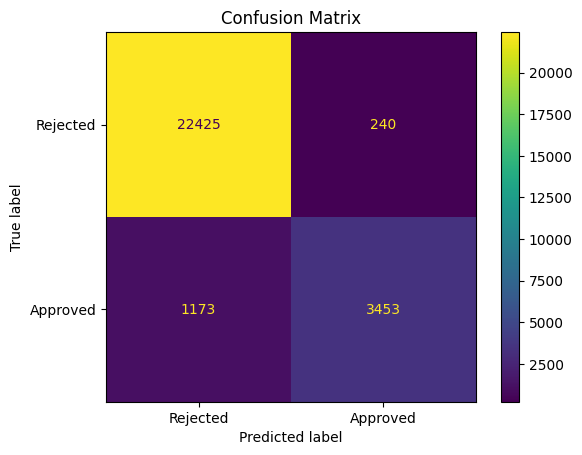

In [71]:
model_xgb = XGBClassifier()
print("Model Summary - XGBoost:\n")
model_evaluate(model_xgb, X_train_df, y_train, X_val_df, y_val)

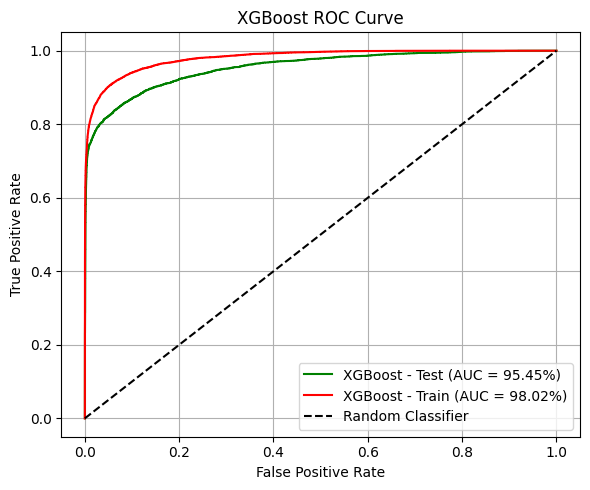

In [72]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

model_xgb.fit(X_train_df, y_train)
xgb_probs = model_xgb.predict_proba(X_val_df)[:, 1]
xgb_probs_train = model_xgb.predict_proba(X_train_df)[:, 1]

fpr, tpr, _ = roc_curve(y_val, xgb_probs)
roc_auc = auc(fpr, tpr)

fpr2, tpr2, _2 = roc_curve(y_train, xgb_probs_train)
roc_auc2 = auc(fpr2, tpr2)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'XGBoost - Test (AUC = {roc_auc*100:.2f}%)', color='green')
plt.plot(fpr2, tpr2, label=f'XGBoost - Train (AUC = {roc_auc2*100:.2f}%)', color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# **`13. Conclusion`**
## **`XGBoost Model Performance on Loan Approval Prediction`**

- The **XGBoost** model achieves **high overall accuracy (94.8%)** and **ROC-AUC (95.45%)** scores on both **training** and **test** sets, indicating **strong learning** without significant overfitting.
- Its **classification** performance is impressive, especially in predicting **rejections (Class 0)**, with a **precision** of **95%** and **recall** of **99%**, resulting in a **near-perfect F1-score** of **97%**.
- However, the model is **more conservative** for **approvals (Class 1)**. While **precision** is **high** at **94%**, **recall** is **notably lower** at **75%**, indicating that some **true approvals** are being **missed**.

# **`14. Submission`**
## **`Test Data`**
## **`14.1. Load Test Data`**

In [73]:
test_df = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")
test_df.head()

id  person_age  person_income person_home_ownership  person_emp_length  \
0  58645          23          69000                  RENT                3.0   
1  58646          26          96000              MORTGAGE                6.0   
2  58647          26          30000                  RENT                5.0   
3  58648          33          50000                  RENT                4.0   
4  58649          26         102000              MORTGAGE                8.0   

         loan_intent loan_grade  loan_amnt  loan_int_rate  \
0    HOMEIMPROVEMENT          F      25000          15.76   
1           PERSONAL          C      10000          12.68   
2            VENTURE          E       4000          17.19   
3  DEBTCONSOLIDATION          A       7000           8.90   
4    HOMEIMPROVEMENT          D      15000          16.32   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.36                         N                           2  
1                 0.10                         Y                           4  
2                 0.13                         Y                           2  
3                 0.14                         N                           7  
4                 0.15                         Y                           4

## **`14.2. Test Data Overview`**

In [74]:
print(f"Number of entries in the data2: {test_df.shape[0]}")
print(f"Number of features in the data2: {test_df.shape[1]}")

Number of entries in the data2: 39098
Number of features in the data2: 12


In [75]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39098 non-null  int64  
 1   person_age                  39098 non-null  int64  
 2   person_income               39098 non-null  int64  
 3   person_home_ownership       39098 non-null  object 
 4   person_emp_length           39098 non-null  float64
 5   loan_intent                 39098 non-null  object 
 6   loan_grade                  39098 non-null  object 
 7   loan_amnt                   39098 non-null  int64  
 8   loan_int_rate               39098 non-null  float64
 9   loan_percent_income         39098 non-null  float64
 10  cb_person_default_on_file   39098 non-null  object 
 11  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.6+ MB


## **`14.3. Check for Missing Values`**

In [76]:
check_missing_values(test_df)

Missing Values:

There are no missing values in the data.


Empty DataFrame
Columns: [values, percentage]
Index: []

## **`14.4. Check for Duplicate Entries`**

In [77]:
test_df.duplicated().sum()

0

## **`14.5. Preprocessing`**

In [78]:
X_test_df = (
    test_df
    .drop('id', axis = 1)
    .assign(
        loan_grade = lambda df_: df_['loan_grade'].map(map_loan_grade),
        cb_person_default_on_file = lambda df_: df_['cb_person_default_on_file'].map({'N': 0, 'Y': 1})
    )
)

In [79]:
X_test_df.head(2)

person_age  person_income person_home_ownership  person_emp_length  \
0          23          69000                  RENT                3.0   
1          26          96000              MORTGAGE                6.0   

       loan_intent  loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0  HOMEIMPROVEMENT           2      25000          15.76                 0.36   
1         PERSONAL           5      10000          12.68                 0.10   

   cb_person_default_on_file  cb_person_cred_hist_length  
0                          0                           2  
1                          1                           4

In [80]:
X_test = preprocessor.transform(X_test_df)

nominal_col = preprocessor.transformers_[0][1].get_feature_names_out()
numerical_col = preprocessor.transformers_[1][1].get_feature_names_out()
cols = list(nominal_col) + list(numerical_col)

X_test_encoded = pd.DataFrame(data = X_test, columns = cols)

In [81]:
X_test_encoded.head(2)

person_home_ownership_OTHER  person_home_ownership_OWN  \
0                          0.0                        0.0   
1                          0.0                        0.0   

   person_home_ownership_RENT  loan_intent_EDUCATION  \
0                         1.0                    0.0   
1                         0.0                    0.0   

   loan_intent_HOMEIMPROVEMENT  loan_intent_MEDICAL  loan_intent_PERSONAL  \
0                          1.0                  0.0                   0.0   
1                          0.0                  0.0                   1.0   

   loan_intent_VENTURE  person_age  person_income  person_emp_length  \
0                  0.0   -0.755803       0.099980          -0.438806   
1                  0.0   -0.264644       0.721103           0.325012   

   loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0   -3.547155   2.678911       1.623189             2.018175   
1   -0.803526   0.109576       0.616458            -0.652212   

   cb_person_default_on_file  cb_person_cred_hist_length  
0                  -0.433202                   -0.943396  
1                   2.308390                   -0.448034

## **`14.6. Prediction on Test Data`**

In [82]:
y_pred_test = model_xgb.predict(X_test_encoded)
y_pred_test

array([1, 0, 1, ..., 0, 0, 1])

### **`Prediction - Probabilities`**

In [83]:
y_pred_test_prob = np.round(model_xgb.predict_proba(X_test_encoded), decimals = 2)
loan_status = y_pred_test_prob[:, 1]
loan_status_df = pd.DataFrame(loan_status, columns = ['loan_status'])
loan_status_df

loan_status
0             1.00
1             0.02
2             0.51
3             0.01
4             0.03
...            ...
39093         0.08
39094         0.01
39095         0.01
39096         0.28
39097         0.98

[39098 rows x 1 columns]

## **`14.7. Final Submission`**

In [84]:
submission_df = pd.concat([test_df, loan_status_df], axis = 1)
submission = submission_df[['id', 'loan_status']]
submission

id  loan_status
0      58645         1.00
1      58646         0.02
2      58647         0.51
3      58648         0.01
4      58649         0.03
...      ...          ...
39093  97738         0.08
39094  97739         0.01
39095  97740         0.01
39096  97741         0.28
39097  97742         0.98

[39098 rows x 2 columns]

In [85]:
submission.to_csv('/kaggle/working/submission.csv', index=False)